In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 40
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b50','k7_b50','k9_b50','k11_b50','k13_b50','k15_b50','k17_b50','k19_b50','k21_b50']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_glcm_JointEntropy_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_RunLengthNonUniformityNormalized_glrlm_RunPercentage_glrlm_GrayLevelVariance_glrlm_RunEntropy_glrlm_LowGrayLevelRunEmphasis_glrlm_HighGrayLevelRunEmphasis_glrlm_ShortRunLowGrayLevelEmphasis_glrlm_ShortRunHighGrayLevelEmphasis_glrlm_LongRunLowGrayLevelEmphasis_glrlm_LongRunHighGrayLevelEmphasis_ngtdm_Coarseness_ngtdm_

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 468)
(3944610, 8)
validation
(464344, 468)
(464344, 8)
test
(574820, 468)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 468)]             0         


 dense (Dense)               (None, 1024)              480256    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1170312 (4.46 MB)


Trainable params: 1170312 (4.46 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 8:50 - loss: 2.3943 - STD: 0.0824 - MAE: 0.2199

  4/395 [..............................] - ETA: 6s - loss: 2.1764 - STD: 0.0556 - MAE: 0.2176  

  8/395 [..............................] - ETA: 5s - loss: 2.1339 - STD: 0.0547 - MAE: 0.2168

 12/395 [..............................] - ETA: 5s - loss: 2.1155 - STD: 0.0536 - MAE: 0.2165

 16/395 [>.............................] - ETA: 5s - loss: 2.1012 - STD: 0.0480 - MAE: 0.2166

 20/395 [>.............................] - ETA: 5s - loss: 2.0931 - STD: 0.0437 - MAE: 0.2167

 24/395 [>.............................] - ETA: 5s - loss: 2.0872 - STD: 0.0424 - MAE: 0.2167

 28/395 [=>............................] - ETA: 5s - loss: 2.0823 - STD: 0.0414 - MAE: 0.2167

 32/395 [=>............................] - ETA: 5s - loss: 2.0787 - STD: 0.0399 - MAE: 0.2167

 36/395 [=>............................] - ETA: 5s - loss: 2.0754 - STD: 0.0393 - MAE: 0.2167

 40/395 [==>...........................] - ETA: 4s - loss: 2.0722 - STD: 0.0389 - MAE: 0.2166

 44/395 [==>...........................] - ETA: 4s - loss: 2.0694 - STD: 0.0381 - MAE: 0.2166

 48/395 [==>...........................] - ETA: 4s - loss: 2.0662 - STD: 0.0375 - MAE: 0.2166

 52/395 [==>...........................] - ETA: 4s - loss: 2.0625 - STD: 0.0372 - MAE: 0.2165

 56/395 [===>..........................] - ETA: 4s - loss: 2.0578 - STD: 0.0372 - MAE: 0.2163

 60/395 [===>..........................] - ETA: 4s - loss: 2.0519 - STD: 0.0377 - MAE: 0.2161

 64/395 [===>..........................] - ETA: 4s - loss: 2.0452 - STD: 0.0386 - MAE: 0.2158

 68/395 [====>.........................] - ETA: 4s - loss: 2.0375 - STD: 0.0398 - MAE: 0.2154

 72/395 [====>.........................] - ETA: 4s - loss: 2.0291 - STD: 0.0411 - MAE: 0.2150

 76/395 [====>.........................] - ETA: 4s - loss: 2.0201 - STD: 0.0426 - MAE: 0.2146

 80/395 [=====>........................] - ETA: 4s - loss: 2.0106 - STD: 0.0442 - MAE: 0.2141

 84/395 [=====>........................] - ETA: 4s - loss: 2.0005 - STD: 0.0459 - MAE: 0.2136

 88/395 [=====>........................] - ETA: 4s - loss: 1.9899 - STD: 0.0476 - MAE: 0.2130

 92/395 [=====>........................] - ETA: 4s - loss: 1.9783 - STD: 0.0494 - MAE: 0.2124

 96/395 [======>.......................] - ETA: 4s - loss: 1.9655 - STD: 0.0513 - MAE: 0.2117

100/395 [======>.......................] - ETA: 4s - loss: 1.9522 - STD: 0.0533 - MAE: 0.2110

104/395 [======>.......................] - ETA: 3s - loss: 1.9387 - STD: 0.0553 - MAE: 0.2102

108/395 [=======>......................] - ETA: 3s - loss: 1.9252 - STD: 0.0575 - MAE: 0.2094

112/395 [=======>......................] - ETA: 3s - loss: 1.9113 - STD: 0.0597 - MAE: 0.2086

116/395 [=======>......................] - ETA: 3s - loss: 1.8978 - STD: 0.0619 - MAE: 0.2077

120/395 [========>.....................] - ETA: 3s - loss: 1.8843 - STD: 0.0641 - MAE: 0.2069

124/395 [========>.....................] - ETA: 3s - loss: 1.8712 - STD: 0.0662 - MAE: 0.2060

128/395 [========>.....................] - ETA: 3s - loss: 1.8587 - STD: 0.0683 - MAE: 0.2052

132/395 [=========>....................] - ETA: 3s - loss: 1.8465 - STD: 0.0704 - MAE: 0.2044

136/395 [=========>....................] - ETA: 3s - loss: 1.8346 - STD: 0.0723 - MAE: 0.2036

140/395 [=========>....................] - ETA: 3s - loss: 1.8230 - STD: 0.0743 - MAE: 0.2028

144/395 [=========>....................] - ETA: 3s - loss: 1.8119 - STD: 0.0762 - MAE: 0.2020

148/395 [==========>...................] - ETA: 3s - loss: 1.8011 - STD: 0.0781 - MAE: 0.2013

152/395 [==========>...................] - ETA: 3s - loss: 1.7910 - STD: 0.0799 - MAE: 0.2006

156/395 [==========>...................] - ETA: 3s - loss: 1.7813 - STD: 0.0816 - MAE: 0.1999

160/395 [===========>..................] - ETA: 3s - loss: 1.7719 - STD: 0.0833 - MAE: 0.1992

164/395 [===========>..................] - ETA: 3s - loss: 1.7627 - STD: 0.0849 - MAE: 0.1986

168/395 [===========>..................] - ETA: 3s - loss: 1.7541 - STD: 0.0864 - MAE: 0.1979

172/395 [============>.................] - ETA: 3s - loss: 1.7457 - STD: 0.0879 - MAE: 0.1973

176/395 [============>.................] - ETA: 2s - loss: 1.7375 - STD: 0.0893 - MAE: 0.1967

180/395 [============>.................] - ETA: 2s - loss: 1.7294 - STD: 0.0907 - MAE: 0.1962

184/395 [============>.................] - ETA: 2s - loss: 1.7217 - STD: 0.0921 - MAE: 0.1956

188/395 [=============>................] - ETA: 2s - loss: 1.7144 - STD: 0.0934 - MAE: 0.1951

192/395 [=============>................] - ETA: 2s - loss: 1.7073 - STD: 0.0946 - MAE: 0.1945

196/395 [=============>................] - ETA: 2s - loss: 1.7004 - STD: 0.0958 - MAE: 0.1940

200/395 [==============>...............] - ETA: 2s - loss: 1.6935 - STD: 0.0970 - MAE: 0.1935

204/395 [==============>...............] - ETA: 2s - loss: 1.6869 - STD: 0.0981 - MAE: 0.1931

208/395 [==============>...............] - ETA: 2s - loss: 1.6803 - STD: 0.0993 - MAE: 0.1926

212/395 [===============>..............] - ETA: 2s - loss: 1.6740 - STD: 0.1003 - MAE: 0.1921

216/395 [===============>..............] - ETA: 2s - loss: 1.6680 - STD: 0.1014 - MAE: 0.1917

220/395 [===============>..............] - ETA: 2s - loss: 1.6621 - STD: 0.1024 - MAE: 0.1912

224/395 [================>.............] - ETA: 2s - loss: 1.6561 - STD: 0.1034 - MAE: 0.1908

228/395 [================>.............] - ETA: 2s - loss: 1.6513 - STD: 0.1044 - MAE: 0.1904

232/395 [================>.............] - ETA: 2s - loss: 1.6458 - STD: 0.1053 - MAE: 0.1899

236/395 [================>.............] - ETA: 2s - loss: 1.6404 - STD: 0.1062 - MAE: 0.1895

240/395 [=================>............] - ETA: 2s - loss: 1.6351 - STD: 0.1071 - MAE: 0.1891

244/395 [=================>............] - ETA: 2s - loss: 1.6300 - STD: 0.1080 - MAE: 0.1888

248/395 [=================>............] - ETA: 2s - loss: 1.6250 - STD: 0.1089 - MAE: 0.1884

252/395 [==================>...........] - ETA: 2s - loss: 1.6201 - STD: 0.1097 - MAE: 0.1880

256/395 [==================>...........] - ETA: 2s - loss: 1.6155 - STD: 0.1105 - MAE: 0.1877

260/395 [==================>...........] - ETA: 2s - loss: 1.6109 - STD: 0.1113 - MAE: 0.1873

264/395 [===================>..........] - ETA: 2s - loss: 1.6064 - STD: 0.1121 - MAE: 0.1870

268/395 [===================>..........] - ETA: 2s - loss: 1.6018 - STD: 0.1128 - MAE: 0.1866

272/395 [===================>..........] - ETA: 1s - loss: 1.5975 - STD: 0.1136 - MAE: 0.1863

276/395 [===================>..........] - ETA: 1s - loss: 1.5934 - STD: 0.1143 - MAE: 0.1860

280/395 [====================>.........] - ETA: 1s - loss: 1.5893 - STD: 0.1150 - MAE: 0.1857

284/395 [====================>.........] - ETA: 1s - loss: 1.5852 - STD: 0.1157 - MAE: 0.1854

288/395 [====================>.........] - ETA: 1s - loss: 1.5813 - STD: 0.1164 - MAE: 0.1851

292/395 [=====================>........] - ETA: 1s - loss: 1.5774 - STD: 0.1170 - MAE: 0.1847

296/395 [=====================>........] - ETA: 1s - loss: 1.5734 - STD: 0.1177 - MAE: 0.1844

300/395 [=====================>........] - ETA: 1s - loss: 1.5696 - STD: 0.1183 - MAE: 0.1841

304/395 [======================>.......] - ETA: 1s - loss: 1.5658 - STD: 0.1190 - MAE: 0.1839

308/395 [======================>.......] - ETA: 1s - loss: 1.5622 - STD: 0.1196 - MAE: 0.1836

312/395 [======================>.......] - ETA: 1s - loss: 1.5587 - STD: 0.1202 - MAE: 0.1833

316/395 [=======================>......] - ETA: 1s - loss: 1.5552 - STD: 0.1208 - MAE: 0.1830

320/395 [=======================>......] - ETA: 1s - loss: 1.5519 - STD: 0.1213 - MAE: 0.1828

324/395 [=======================>......] - ETA: 1s - loss: 1.5486 - STD: 0.1219 - MAE: 0.1825

328/395 [=======================>......] - ETA: 1s - loss: 1.5453 - STD: 0.1225 - MAE: 0.1823

332/395 [========================>.....] - ETA: 0s - loss: 1.5421 - STD: 0.1230 - MAE: 0.1820

336/395 [========================>.....] - ETA: 0s - loss: 1.5389 - STD: 0.1235 - MAE: 0.1818

340/395 [========================>.....] - ETA: 0s - loss: 1.5357 - STD: 0.1241 - MAE: 0.1815

344/395 [=========================>....] - ETA: 0s - loss: 1.5327 - STD: 0.1246 - MAE: 0.1813

348/395 [=========================>....] - ETA: 0s - loss: 1.5297 - STD: 0.1251 - MAE: 0.1810

352/395 [=========================>....] - ETA: 0s - loss: 1.5267 - STD: 0.1256 - MAE: 0.1808

356/395 [==========================>...] - ETA: 0s - loss: 1.5237 - STD: 0.1261 - MAE: 0.1806

360/395 [==========================>...] - ETA: 0s - loss: 1.5207 - STD: 0.1266 - MAE: 0.1803

364/395 [==========================>...] - ETA: 0s - loss: 1.5178 - STD: 0.1270 - MAE: 0.1801

368/395 [==========================>...] - ETA: 0s - loss: 1.5149 - STD: 0.1275 - MAE: 0.1799

372/395 [===========================>..] - ETA: 0s - loss: 1.5121 - STD: 0.1280 - MAE: 0.1796

376/395 [===========================>..] - ETA: 0s - loss: 1.5094 - STD: 0.1285 - MAE: 0.1794

380/395 [===========================>..] - ETA: 0s - loss: 1.5068 - STD: 0.1289 - MAE: 0.1792

384/395 [============================>.] - ETA: 0s - loss: 1.5042 - STD: 0.1294 - MAE: 0.1790

388/395 [============================>.] - ETA: 0s - loss: 1.5016 - STD: 0.1298 - MAE: 0.1788

392/395 [============================>.] - ETA: 0s - loss: 1.4990 - STD: 0.1302 - MAE: 0.1786

395/395 [==============================] - 8s 18ms/step - loss: 1.4970 - STD: 0.1305 - MAE: 0.1784 - val_loss: 1.3553 - val_STD: 0.1762 - val_MAE: 0.1594


Epoch 2/10000


  1/395 [..............................] - ETA: 17s - loss: 1.2346 - STD: 0.1728 - MAE: 0.1571

  5/395 [..............................] - ETA: 5s - loss: 1.2437 - STD: 0.1731 - MAE: 0.1576 

  9/395 [..............................] - ETA: 5s - loss: 1.2429 - STD: 0.1730 - MAE: 0.1577

 13/395 [..............................] - ETA: 5s - loss: 1.2442 - STD: 0.1730 - MAE: 0.1577

 17/395 [>.............................] - ETA: 5s - loss: 1.2483 - STD: 0.1730 - MAE: 0.1579

 21/395 [>.............................] - ETA: 4s - loss: 1.2477 - STD: 0.1729 - MAE: 0.1579

 25/395 [>.............................] - ETA: 4s - loss: 1.2471 - STD: 0.1729 - MAE: 0.1579

 29/395 [=>............................] - ETA: 4s - loss: 1.2469 - STD: 0.1729 - MAE: 0.1579

 33/395 [=>............................] - ETA: 4s - loss: 1.2462 - STD: 0.1729 - MAE: 0.1579

 37/395 [=>............................] - ETA: 4s - loss: 1.2450 - STD: 0.1730 - MAE: 0.1578

 41/395 [==>...........................] - ETA: 4s - loss: 1.2436 - STD: 0.1731 - MAE: 0.1577

 45/395 [==>...........................] - ETA: 4s - loss: 1.2425 - STD: 0.1733 - MAE: 0.1576

 49/395 [==>...........................] - ETA: 4s - loss: 1.2422 - STD: 0.1734 - MAE: 0.1575

 53/395 [===>..........................] - ETA: 4s - loss: 1.2410 - STD: 0.1735 - MAE: 0.1574

 57/395 [===>..........................] - ETA: 4s - loss: 1.2400 - STD: 0.1737 - MAE: 0.1573

 62/395 [===>..........................] - ETA: 4s - loss: 1.2395 - STD: 0.1737 - MAE: 0.1573

 67/395 [====>.........................] - ETA: 4s - loss: 1.2379 - STD: 0.1739 - MAE: 0.1572

 71/395 [====>.........................] - ETA: 4s - loss: 1.2372 - STD: 0.1739 - MAE: 0.1571

 75/395 [====>.........................] - ETA: 4s - loss: 1.2366 - STD: 0.1740 - MAE: 0.1571

 79/395 [=====>........................] - ETA: 4s - loss: 1.2364 - STD: 0.1741 - MAE: 0.1570

 83/395 [=====>........................] - ETA: 4s - loss: 1.2359 - STD: 0.1742 - MAE: 0.1569

 87/395 [=====>........................] - ETA: 4s - loss: 1.2356 - STD: 0.1743 - MAE: 0.1569

 92/395 [=====>........................] - ETA: 3s - loss: 1.2351 - STD: 0.1744 - MAE: 0.1568

 96/395 [======>.......................] - ETA: 3s - loss: 1.2340 - STD: 0.1745 - MAE: 0.1567

100/395 [======>.......................] - ETA: 3s - loss: 1.2331 - STD: 0.1746 - MAE: 0.1567

104/395 [======>.......................] - ETA: 3s - loss: 1.2323 - STD: 0.1747 - MAE: 0.1566

108/395 [=======>......................] - ETA: 3s - loss: 1.2312 - STD: 0.1747 - MAE: 0.1565

112/395 [=======>......................] - ETA: 3s - loss: 1.2303 - STD: 0.1749 - MAE: 0.1564

116/395 [=======>......................] - ETA: 3s - loss: 1.2294 - STD: 0.1750 - MAE: 0.1563

121/395 [========>.....................] - ETA: 3s - loss: 1.2280 - STD: 0.1751 - MAE: 0.1562

126/395 [========>.....................] - ETA: 3s - loss: 1.2269 - STD: 0.1752 - MAE: 0.1561

131/395 [========>.....................] - ETA: 3s - loss: 1.2258 - STD: 0.1754 - MAE: 0.1560

136/395 [=========>....................] - ETA: 3s - loss: 1.2249 - STD: 0.1755 - MAE: 0.1559

141/395 [=========>....................] - ETA: 3s - loss: 1.2237 - STD: 0.1756 - MAE: 0.1558

145/395 [==========>...................] - ETA: 3s - loss: 1.2227 - STD: 0.1758 - MAE: 0.1557

150/395 [==========>...................] - ETA: 3s - loss: 1.2218 - STD: 0.1759 - MAE: 0.1556

155/395 [==========>...................] - ETA: 3s - loss: 1.2208 - STD: 0.1760 - MAE: 0.1555

160/395 [===========>..................] - ETA: 3s - loss: 1.2200 - STD: 0.1762 - MAE: 0.1554

165/395 [===========>..................] - ETA: 2s - loss: 1.2192 - STD: 0.1763 - MAE: 0.1553

170/395 [===========>..................] - ETA: 2s - loss: 1.2186 - STD: 0.1765 - MAE: 0.1552

175/395 [============>.................] - ETA: 2s - loss: 1.2177 - STD: 0.1766 - MAE: 0.1551

180/395 [============>.................] - ETA: 2s - loss: 1.2175 - STD: 0.1767 - MAE: 0.1551

185/395 [=============>................] - ETA: 2s - loss: 1.2167 - STD: 0.1768 - MAE: 0.1550

190/395 [=============>................] - ETA: 2s - loss: 1.2158 - STD: 0.1769 - MAE: 0.1549

195/395 [=============>................] - ETA: 2s - loss: 1.2150 - STD: 0.1770 - MAE: 0.1548

200/395 [==============>...............] - ETA: 2s - loss: 1.2142 - STD: 0.1771 - MAE: 0.1547

205/395 [==============>...............] - ETA: 2s - loss: 1.2132 - STD: 0.1773 - MAE: 0.1546

210/395 [==============>...............] - ETA: 2s - loss: 1.2123 - STD: 0.1774 - MAE: 0.1545

215/395 [===============>..............] - ETA: 2s - loss: 1.2113 - STD: 0.1775 - MAE: 0.1544

220/395 [===============>..............] - ETA: 2s - loss: 1.2104 - STD: 0.1776 - MAE: 0.1544

225/395 [================>.............] - ETA: 2s - loss: 1.2094 - STD: 0.1777 - MAE: 0.1543

230/395 [================>.............] - ETA: 2s - loss: 1.2084 - STD: 0.1779 - MAE: 0.1541

235/395 [================>.............] - ETA: 2s - loss: 1.2073 - STD: 0.1780 - MAE: 0.1540

239/395 [=================>............] - ETA: 1s - loss: 1.2065 - STD: 0.1781 - MAE: 0.1539

244/395 [=================>............] - ETA: 1s - loss: 1.2056 - STD: 0.1782 - MAE: 0.1538

249/395 [=================>............] - ETA: 1s - loss: 1.2048 - STD: 0.1784 - MAE: 0.1538

254/395 [==================>...........] - ETA: 1s - loss: 1.2041 - STD: 0.1785 - MAE: 0.1537

259/395 [==================>...........] - ETA: 1s - loss: 1.2034 - STD: 0.1786 - MAE: 0.1536

263/395 [==================>...........] - ETA: 1s - loss: 1.2027 - STD: 0.1787 - MAE: 0.1535

268/395 [===================>..........] - ETA: 1s - loss: 1.2018 - STD: 0.1789 - MAE: 0.1534

273/395 [===================>..........] - ETA: 1s - loss: 1.2009 - STD: 0.1790 - MAE: 0.1533

278/395 [====================>.........] - ETA: 1s - loss: 1.2000 - STD: 0.1791 - MAE: 0.1532

283/395 [====================>.........] - ETA: 1s - loss: 1.1991 - STD: 0.1792 - MAE: 0.1531

288/395 [====================>.........] - ETA: 1s - loss: 1.1981 - STD: 0.1794 - MAE: 0.1530

293/395 [=====================>........] - ETA: 1s - loss: 1.1972 - STD: 0.1795 - MAE: 0.1529

298/395 [=====================>........] - ETA: 1s - loss: 1.1964 - STD: 0.1796 - MAE: 0.1528

303/395 [======================>.......] - ETA: 1s - loss: 1.1957 - STD: 0.1797 - MAE: 0.1527

308/395 [======================>.......] - ETA: 1s - loss: 1.1948 - STD: 0.1799 - MAE: 0.1527

313/395 [======================>.......] - ETA: 1s - loss: 1.1940 - STD: 0.1800 - MAE: 0.1526

318/395 [=======================>......] - ETA: 0s - loss: 1.1932 - STD: 0.1801 - MAE: 0.1525

323/395 [=======================>......] - ETA: 0s - loss: 1.1923 - STD: 0.1802 - MAE: 0.1524

328/395 [=======================>......] - ETA: 0s - loss: 1.1913 - STD: 0.1803 - MAE: 0.1523

333/395 [========================>.....] - ETA: 0s - loss: 1.1904 - STD: 0.1805 - MAE: 0.1522

338/395 [========================>.....] - ETA: 0s - loss: 1.1896 - STD: 0.1806 - MAE: 0.1521

343/395 [=========================>....] - ETA: 0s - loss: 1.1887 - STD: 0.1807 - MAE: 0.1520

347/395 [=========================>....] - ETA: 0s - loss: 1.1881 - STD: 0.1808 - MAE: 0.1519

352/395 [=========================>....] - ETA: 0s - loss: 1.1873 - STD: 0.1809 - MAE: 0.1519

357/395 [==========================>...] - ETA: 0s - loss: 1.1865 - STD: 0.1811 - MAE: 0.1518

362/395 [==========================>...] - ETA: 0s - loss: 1.1856 - STD: 0.1812 - MAE: 0.1517

367/395 [==========================>...] - ETA: 0s - loss: 1.1848 - STD: 0.1813 - MAE: 0.1516

372/395 [===========================>..] - ETA: 0s - loss: 1.1841 - STD: 0.1814 - MAE: 0.1515

377/395 [===========================>..] - ETA: 0s - loss: 1.1832 - STD: 0.1815 - MAE: 0.1514

381/395 [===========================>..] - ETA: 0s - loss: 1.1826 - STD: 0.1816 - MAE: 0.1514

386/395 [============================>.] - ETA: 0s - loss: 1.1818 - STD: 0.1817 - MAE: 0.1513

391/395 [============================>.] - ETA: 0s - loss: 1.1811 - STD: 0.1818 - MAE: 0.1512

395/395 [==============================] - 5s 14ms/step - loss: 1.1806 - STD: 0.1819 - MAE: 0.1511 - val_loss: 1.2573 - val_STD: 0.1932 - val_MAE: 0.1480


Epoch 3/10000


  1/395 [..............................] - ETA: 15s - loss: 1.1123 - STD: 0.1922 - MAE: 0.1435

  5/395 [..............................] - ETA: 4s - loss: 1.1172 - STD: 0.1925 - MAE: 0.1437 

 10/395 [..............................] - ETA: 4s - loss: 1.1153 - STD: 0.1913 - MAE: 0.1441

 15/395 [>.............................] - ETA: 4s - loss: 1.1135 - STD: 0.1916 - MAE: 0.1439

 20/395 [>.............................] - ETA: 4s - loss: 1.1124 - STD: 0.1917 - MAE: 0.1438

 25/395 [>.............................] - ETA: 4s - loss: 1.1109 - STD: 0.1917 - MAE: 0.1437

 30/395 [=>............................] - ETA: 4s - loss: 1.1109 - STD: 0.1917 - MAE: 0.1437

 35/395 [=>............................] - ETA: 4s - loss: 1.1111 - STD: 0.1917 - MAE: 0.1437

 40/395 [==>...........................] - ETA: 4s - loss: 1.1112 - STD: 0.1919 - MAE: 0.1437

 44/395 [==>...........................] - ETA: 4s - loss: 1.1119 - STD: 0.1919 - MAE: 0.1437

 48/395 [==>...........................] - ETA: 4s - loss: 1.1123 - STD: 0.1919 - MAE: 0.1438

 52/395 [==>...........................] - ETA: 4s - loss: 1.1128 - STD: 0.1919 - MAE: 0.1438

 56/395 [===>..........................] - ETA: 4s - loss: 1.1127 - STD: 0.1919 - MAE: 0.1438

 59/395 [===>..........................] - ETA: 4s - loss: 1.1121 - STD: 0.1919 - MAE: 0.1438

 63/395 [===>..........................] - ETA: 4s - loss: 1.1113 - STD: 0.1919 - MAE: 0.1437

 67/395 [====>.........................] - ETA: 4s - loss: 1.1111 - STD: 0.1920 - MAE: 0.1437

 72/395 [====>.........................] - ETA: 4s - loss: 1.1103 - STD: 0.1921 - MAE: 0.1436

 76/395 [====>.........................] - ETA: 4s - loss: 1.1097 - STD: 0.1921 - MAE: 0.1435

 80/395 [=====>........................] - ETA: 4s - loss: 1.1093 - STD: 0.1922 - MAE: 0.1435

 85/395 [=====>........................] - ETA: 3s - loss: 1.1084 - STD: 0.1923 - MAE: 0.1434

 90/395 [=====>........................] - ETA: 3s - loss: 1.1083 - STD: 0.1924 - MAE: 0.1433

 95/395 [======>.......................] - ETA: 3s - loss: 1.1081 - STD: 0.1925 - MAE: 0.1433

 99/395 [======>.......................] - ETA: 3s - loss: 1.1079 - STD: 0.1926 - MAE: 0.1433

103/395 [======>.......................] - ETA: 3s - loss: 1.1076 - STD: 0.1926 - MAE: 0.1432

107/395 [=======>......................] - ETA: 3s - loss: 1.1071 - STD: 0.1927 - MAE: 0.1432

111/395 [=======>......................] - ETA: 3s - loss: 1.1072 - STD: 0.1927 - MAE: 0.1432

115/395 [=======>......................] - ETA: 3s - loss: 1.1066 - STD: 0.1928 - MAE: 0.1431

119/395 [========>.....................] - ETA: 3s - loss: 1.1059 - STD: 0.1929 - MAE: 0.1430

123/395 [========>.....................] - ETA: 3s - loss: 1.1056 - STD: 0.1930 - MAE: 0.1430

127/395 [========>.....................] - ETA: 3s - loss: 1.1057 - STD: 0.1930 - MAE: 0.1430

131/395 [========>.....................] - ETA: 3s - loss: 1.1059 - STD: 0.1931 - MAE: 0.1430

135/395 [=========>....................] - ETA: 3s - loss: 1.1055 - STD: 0.1932 - MAE: 0.1429

139/395 [=========>....................] - ETA: 3s - loss: 1.1052 - STD: 0.1932 - MAE: 0.1429

143/395 [=========>....................] - ETA: 3s - loss: 1.1049 - STD: 0.1933 - MAE: 0.1428

147/395 [==========>...................] - ETA: 3s - loss: 1.1044 - STD: 0.1933 - MAE: 0.1428

151/395 [==========>...................] - ETA: 3s - loss: 1.1040 - STD: 0.1934 - MAE: 0.1428

155/395 [==========>...................] - ETA: 3s - loss: 1.1035 - STD: 0.1935 - MAE: 0.1427

159/395 [===========>..................] - ETA: 3s - loss: 1.1030 - STD: 0.1935 - MAE: 0.1427

163/395 [===========>..................] - ETA: 3s - loss: 1.1026 - STD: 0.1936 - MAE: 0.1426

167/395 [===========>..................] - ETA: 2s - loss: 1.1021 - STD: 0.1936 - MAE: 0.1426

171/395 [===========>..................] - ETA: 2s - loss: 1.1016 - STD: 0.1937 - MAE: 0.1425

175/395 [============>.................] - ETA: 2s - loss: 1.1013 - STD: 0.1937 - MAE: 0.1425

179/395 [============>.................] - ETA: 2s - loss: 1.1008 - STD: 0.1938 - MAE: 0.1424

183/395 [============>.................] - ETA: 2s - loss: 1.1003 - STD: 0.1939 - MAE: 0.1424

187/395 [=============>................] - ETA: 2s - loss: 1.0999 - STD: 0.1939 - MAE: 0.1423

191/395 [=============>................] - ETA: 2s - loss: 1.0995 - STD: 0.1940 - MAE: 0.1423

195/395 [=============>................] - ETA: 2s - loss: 1.0994 - STD: 0.1940 - MAE: 0.1423

199/395 [==============>...............] - ETA: 2s - loss: 1.0992 - STD: 0.1941 - MAE: 0.1422

203/395 [==============>...............] - ETA: 2s - loss: 1.0990 - STD: 0.1941 - MAE: 0.1422

207/395 [==============>...............] - ETA: 2s - loss: 1.0987 - STD: 0.1942 - MAE: 0.1422

211/395 [===============>..............] - ETA: 2s - loss: 1.0985 - STD: 0.1942 - MAE: 0.1421

215/395 [===============>..............] - ETA: 2s - loss: 1.0979 - STD: 0.1943 - MAE: 0.1421

219/395 [===============>..............] - ETA: 2s - loss: 1.0975 - STD: 0.1944 - MAE: 0.1420

223/395 [===============>..............] - ETA: 2s - loss: 1.0970 - STD: 0.1944 - MAE: 0.1420

227/395 [================>.............] - ETA: 2s - loss: 1.0966 - STD: 0.1945 - MAE: 0.1419

232/395 [================>.............] - ETA: 2s - loss: 1.0959 - STD: 0.1946 - MAE: 0.1419

236/395 [================>.............] - ETA: 2s - loss: 1.0954 - STD: 0.1946 - MAE: 0.1418

240/395 [=================>............] - ETA: 2s - loss: 1.0950 - STD: 0.1947 - MAE: 0.1418

244/395 [=================>............] - ETA: 1s - loss: 1.0946 - STD: 0.1948 - MAE: 0.1417

248/395 [=================>............] - ETA: 1s - loss: 1.0941 - STD: 0.1948 - MAE: 0.1417

252/395 [==================>...........] - ETA: 1s - loss: 1.0938 - STD: 0.1949 - MAE: 0.1416

256/395 [==================>...........] - ETA: 1s - loss: 1.0934 - STD: 0.1950 - MAE: 0.1416

260/395 [==================>...........] - ETA: 1s - loss: 1.0933 - STD: 0.1950 - MAE: 0.1416

264/395 [===================>..........] - ETA: 1s - loss: 1.0931 - STD: 0.1950 - MAE: 0.1415

268/395 [===================>..........] - ETA: 1s - loss: 1.0928 - STD: 0.1951 - MAE: 0.1415

272/395 [===================>..........] - ETA: 1s - loss: 1.0927 - STD: 0.1952 - MAE: 0.1415

276/395 [===================>..........] - ETA: 1s - loss: 1.0924 - STD: 0.1952 - MAE: 0.1414

280/395 [====================>.........] - ETA: 1s - loss: 1.0922 - STD: 0.1953 - MAE: 0.1414

284/395 [====================>.........] - ETA: 1s - loss: 1.0918 - STD: 0.1953 - MAE: 0.1414

288/395 [====================>.........] - ETA: 1s - loss: 1.0915 - STD: 0.1954 - MAE: 0.1413

292/395 [=====================>........] - ETA: 1s - loss: 1.0912 - STD: 0.1954 - MAE: 0.1413

296/395 [=====================>........] - ETA: 1s - loss: 1.0907 - STD: 0.1955 - MAE: 0.1412

300/395 [=====================>........] - ETA: 1s - loss: 1.0906 - STD: 0.1955 - MAE: 0.1412

304/395 [======================>.......] - ETA: 1s - loss: 1.0904 - STD: 0.1956 - MAE: 0.1412

308/395 [======================>.......] - ETA: 1s - loss: 1.0901 - STD: 0.1956 - MAE: 0.1411

312/395 [======================>.......] - ETA: 1s - loss: 1.0897 - STD: 0.1957 - MAE: 0.1411

316/395 [=======================>......] - ETA: 1s - loss: 1.0893 - STD: 0.1957 - MAE: 0.1411

320/395 [=======================>......] - ETA: 0s - loss: 1.0889 - STD: 0.1958 - MAE: 0.1410

324/395 [=======================>......] - ETA: 0s - loss: 1.0884 - STD: 0.1958 - MAE: 0.1410

328/395 [=======================>......] - ETA: 0s - loss: 1.0881 - STD: 0.1959 - MAE: 0.1409

332/395 [========================>.....] - ETA: 0s - loss: 1.0878 - STD: 0.1959 - MAE: 0.1409

336/395 [========================>.....] - ETA: 0s - loss: 1.0877 - STD: 0.1959 - MAE: 0.1409

340/395 [========================>.....] - ETA: 0s - loss: 1.0873 - STD: 0.1960 - MAE: 0.1409

344/395 [=========================>....] - ETA: 0s - loss: 1.0872 - STD: 0.1960 - MAE: 0.1408

348/395 [=========================>....] - ETA: 0s - loss: 1.0869 - STD: 0.1961 - MAE: 0.1408

352/395 [=========================>....] - ETA: 0s - loss: 1.0866 - STD: 0.1961 - MAE: 0.1408

356/395 [==========================>...] - ETA: 0s - loss: 1.0863 - STD: 0.1962 - MAE: 0.1407

360/395 [==========================>...] - ETA: 0s - loss: 1.0860 - STD: 0.1962 - MAE: 0.1407

364/395 [==========================>...] - ETA: 0s - loss: 1.0857 - STD: 0.1963 - MAE: 0.1407

368/395 [==========================>...] - ETA: 0s - loss: 1.0856 - STD: 0.1963 - MAE: 0.1406

372/395 [===========================>..] - ETA: 0s - loss: 1.0853 - STD: 0.1964 - MAE: 0.1406

376/395 [===========================>..] - ETA: 0s - loss: 1.0852 - STD: 0.1964 - MAE: 0.1406

380/395 [===========================>..] - ETA: 0s - loss: 1.0851 - STD: 0.1964 - MAE: 0.1406

384/395 [============================>.] - ETA: 0s - loss: 1.0849 - STD: 0.1965 - MAE: 0.1405

388/395 [============================>.] - ETA: 0s - loss: 1.0847 - STD: 0.1965 - MAE: 0.1405

392/395 [============================>.] - ETA: 0s - loss: 1.0843 - STD: 0.1965 - MAE: 0.1405

395/395 [==============================] - 6s 15ms/step - loss: 1.0841 - STD: 0.1966 - MAE: 0.1405 - val_loss: 1.2342 - val_STD: 0.1998 - val_MAE: 0.1440


Epoch 4/10000


  1/395 [..............................] - ETA: 16s - loss: 1.0595 - STD: 0.2000 - MAE: 0.1379

  5/395 [..............................] - ETA: 5s - loss: 1.0577 - STD: 0.2007 - MAE: 0.1374 

  9/395 [..............................] - ETA: 5s - loss: 1.0552 - STD: 0.2007 - MAE: 0.1372

 13/395 [..............................] - ETA: 5s - loss: 1.0544 - STD: 0.2011 - MAE: 0.1370

 17/395 [>.............................] - ETA: 5s - loss: 1.0545 - STD: 0.2010 - MAE: 0.1371

 21/395 [>.............................] - ETA: 5s - loss: 1.0539 - STD: 0.2009 - MAE: 0.1372

 25/395 [>.............................] - ETA: 5s - loss: 1.0529 - STD: 0.2009 - MAE: 0.1371

 29/395 [=>............................] - ETA: 4s - loss: 1.0522 - STD: 0.2010 - MAE: 0.1370

 33/395 [=>............................] - ETA: 4s - loss: 1.0519 - STD: 0.2013 - MAE: 0.1369

 37/395 [=>............................] - ETA: 4s - loss: 1.0508 - STD: 0.2013 - MAE: 0.1368

 41/395 [==>...........................] - ETA: 4s - loss: 1.0496 - STD: 0.2013 - MAE: 0.1368

 45/395 [==>...........................] - ETA: 4s - loss: 1.0491 - STD: 0.2013 - MAE: 0.1367

 49/395 [==>...........................] - ETA: 4s - loss: 1.0484 - STD: 0.2013 - MAE: 0.1367

 53/395 [===>..........................] - ETA: 4s - loss: 1.0484 - STD: 0.2015 - MAE: 0.1366

 57/395 [===>..........................] - ETA: 4s - loss: 1.0482 - STD: 0.2015 - MAE: 0.1366

 61/395 [===>..........................] - ETA: 4s - loss: 1.0481 - STD: 0.2016 - MAE: 0.1366

 65/395 [===>..........................] - ETA: 4s - loss: 1.0483 - STD: 0.2015 - MAE: 0.1366

 69/395 [====>.........................] - ETA: 4s - loss: 1.0479 - STD: 0.2015 - MAE: 0.1365

 73/395 [====>.........................] - ETA: 4s - loss: 1.0472 - STD: 0.2016 - MAE: 0.1365

 77/395 [====>.........................] - ETA: 4s - loss: 1.0467 - STD: 0.2016 - MAE: 0.1365

 81/395 [=====>........................] - ETA: 4s - loss: 1.0465 - STD: 0.2016 - MAE: 0.1364

 85/395 [=====>........................] - ETA: 4s - loss: 1.0459 - STD: 0.2017 - MAE: 0.1364

 89/395 [=====>........................] - ETA: 4s - loss: 1.0458 - STD: 0.2017 - MAE: 0.1364

 93/395 [======>.......................] - ETA: 4s - loss: 1.0459 - STD: 0.2018 - MAE: 0.1363

 97/395 [======>.......................] - ETA: 4s - loss: 1.0462 - STD: 0.2018 - MAE: 0.1363

101/395 [======>.......................] - ETA: 3s - loss: 1.0464 - STD: 0.2019 - MAE: 0.1363

105/395 [======>.......................] - ETA: 3s - loss: 1.0466 - STD: 0.2019 - MAE: 0.1363

109/395 [=======>......................] - ETA: 3s - loss: 1.0473 - STD: 0.2020 - MAE: 0.1363

113/395 [=======>......................] - ETA: 3s - loss: 1.0479 - STD: 0.2020 - MAE: 0.1364

117/395 [=======>......................] - ETA: 3s - loss: 1.0482 - STD: 0.2020 - MAE: 0.1364

121/395 [========>.....................] - ETA: 3s - loss: 1.0480 - STD: 0.2020 - MAE: 0.1364

125/395 [========>.....................] - ETA: 3s - loss: 1.0477 - STD: 0.2020 - MAE: 0.1364

129/395 [========>.....................] - ETA: 3s - loss: 1.0475 - STD: 0.2020 - MAE: 0.1363

133/395 [=========>....................] - ETA: 3s - loss: 1.0472 - STD: 0.2021 - MAE: 0.1363

137/395 [=========>....................] - ETA: 3s - loss: 1.0470 - STD: 0.2021 - MAE: 0.1363

141/395 [=========>....................] - ETA: 3s - loss: 1.0466 - STD: 0.2021 - MAE: 0.1363

145/395 [==========>...................] - ETA: 3s - loss: 1.0463 - STD: 0.2021 - MAE: 0.1362

149/395 [==========>...................] - ETA: 3s - loss: 1.0458 - STD: 0.2021 - MAE: 0.1362

153/395 [==========>...................] - ETA: 3s - loss: 1.0454 - STD: 0.2022 - MAE: 0.1362

157/395 [==========>...................] - ETA: 3s - loss: 1.0452 - STD: 0.2022 - MAE: 0.1361

161/395 [===========>..................] - ETA: 3s - loss: 1.0452 - STD: 0.2022 - MAE: 0.1361

165/395 [===========>..................] - ETA: 3s - loss: 1.0453 - STD: 0.2023 - MAE: 0.1361

169/395 [===========>..................] - ETA: 3s - loss: 1.0454 - STD: 0.2023 - MAE: 0.1361

173/395 [============>.................] - ETA: 2s - loss: 1.0452 - STD: 0.2024 - MAE: 0.1361

177/395 [============>.................] - ETA: 2s - loss: 1.0453 - STD: 0.2024 - MAE: 0.1361

181/395 [============>.................] - ETA: 2s - loss: 1.0454 - STD: 0.2024 - MAE: 0.1361

185/395 [=============>................] - ETA: 2s - loss: 1.0453 - STD: 0.2024 - MAE: 0.1361

189/395 [=============>................] - ETA: 2s - loss: 1.0454 - STD: 0.2024 - MAE: 0.1361

193/395 [=============>................] - ETA: 2s - loss: 1.0452 - STD: 0.2024 - MAE: 0.1360

197/395 [=============>................] - ETA: 2s - loss: 1.0451 - STD: 0.2025 - MAE: 0.1360

201/395 [==============>...............] - ETA: 2s - loss: 1.0450 - STD: 0.2025 - MAE: 0.1360

205/395 [==============>...............] - ETA: 2s - loss: 1.0446 - STD: 0.2025 - MAE: 0.1360

209/395 [==============>...............] - ETA: 2s - loss: 1.0441 - STD: 0.2025 - MAE: 0.1359

213/395 [===============>..............] - ETA: 2s - loss: 1.0439 - STD: 0.2025 - MAE: 0.1359

217/395 [===============>..............] - ETA: 2s - loss: 1.0437 - STD: 0.2026 - MAE: 0.1359

221/395 [===============>..............] - ETA: 2s - loss: 1.0434 - STD: 0.2026 - MAE: 0.1359

225/395 [================>.............] - ETA: 2s - loss: 1.0433 - STD: 0.2026 - MAE: 0.1359

229/395 [================>.............] - ETA: 2s - loss: 1.0431 - STD: 0.2027 - MAE: 0.1358

233/395 [================>.............] - ETA: 2s - loss: 1.0429 - STD: 0.2027 - MAE: 0.1358

237/395 [=================>............] - ETA: 2s - loss: 1.0427 - STD: 0.2027 - MAE: 0.1358

241/395 [=================>............] - ETA: 2s - loss: 1.0425 - STD: 0.2027 - MAE: 0.1358

245/395 [=================>............] - ETA: 2s - loss: 1.0421 - STD: 0.2027 - MAE: 0.1357

249/395 [=================>............] - ETA: 1s - loss: 1.0418 - STD: 0.2028 - MAE: 0.1357

253/395 [==================>...........] - ETA: 1s - loss: 1.0416 - STD: 0.2028 - MAE: 0.1357

257/395 [==================>...........] - ETA: 1s - loss: 1.0415 - STD: 0.2028 - MAE: 0.1357

261/395 [==================>...........] - ETA: 1s - loss: 1.0412 - STD: 0.2028 - MAE: 0.1357

265/395 [===================>..........] - ETA: 1s - loss: 1.0409 - STD: 0.2029 - MAE: 0.1356

269/395 [===================>..........] - ETA: 1s - loss: 1.0406 - STD: 0.2029 - MAE: 0.1356

273/395 [===================>..........] - ETA: 1s - loss: 1.0402 - STD: 0.2029 - MAE: 0.1356

277/395 [====================>.........] - ETA: 1s - loss: 1.0399 - STD: 0.2030 - MAE: 0.1355

281/395 [====================>.........] - ETA: 1s - loss: 1.0397 - STD: 0.2030 - MAE: 0.1355

285/395 [====================>.........] - ETA: 1s - loss: 1.0395 - STD: 0.2030 - MAE: 0.1355

289/395 [====================>.........] - ETA: 1s - loss: 1.0394 - STD: 0.2031 - MAE: 0.1355

293/395 [=====================>........] - ETA: 1s - loss: 1.0392 - STD: 0.2031 - MAE: 0.1354

297/395 [=====================>........] - ETA: 1s - loss: 1.0389 - STD: 0.2031 - MAE: 0.1354

301/395 [=====================>........] - ETA: 1s - loss: 1.0388 - STD: 0.2032 - MAE: 0.1354

305/395 [======================>.......] - ETA: 1s - loss: 1.0386 - STD: 0.2032 - MAE: 0.1354

309/395 [======================>.......] - ETA: 1s - loss: 1.0383 - STD: 0.2032 - MAE: 0.1353

313/395 [======================>.......] - ETA: 1s - loss: 1.0380 - STD: 0.2032 - MAE: 0.1353

317/395 [=======================>......] - ETA: 1s - loss: 1.0379 - STD: 0.2033 - MAE: 0.1353

321/395 [=======================>......] - ETA: 0s - loss: 1.0377 - STD: 0.2033 - MAE: 0.1353

325/395 [=======================>......] - ETA: 0s - loss: 1.0375 - STD: 0.2033 - MAE: 0.1352

329/395 [=======================>......] - ETA: 0s - loss: 1.0372 - STD: 0.2034 - MAE: 0.1352

333/395 [========================>.....] - ETA: 0s - loss: 1.0371 - STD: 0.2034 - MAE: 0.1352

337/395 [========================>.....] - ETA: 0s - loss: 1.0369 - STD: 0.2034 - MAE: 0.1352

341/395 [========================>.....] - ETA: 0s - loss: 1.0367 - STD: 0.2034 - MAE: 0.1352

345/395 [=========================>....] - ETA: 0s - loss: 1.0365 - STD: 0.2035 - MAE: 0.1351

349/395 [=========================>....] - ETA: 0s - loss: 1.0363 - STD: 0.2035 - MAE: 0.1351

353/395 [=========================>....] - ETA: 0s - loss: 1.0361 - STD: 0.2035 - MAE: 0.1351

357/395 [==========================>...] - ETA: 0s - loss: 1.0358 - STD: 0.2035 - MAE: 0.1351

361/395 [==========================>...] - ETA: 0s - loss: 1.0355 - STD: 0.2036 - MAE: 0.1350

365/395 [==========================>...] - ETA: 0s - loss: 1.0355 - STD: 0.2036 - MAE: 0.1350

369/395 [===========================>..] - ETA: 0s - loss: 1.0352 - STD: 0.2036 - MAE: 0.1350

373/395 [===========================>..] - ETA: 0s - loss: 1.0349 - STD: 0.2037 - MAE: 0.1350

377/395 [===========================>..] - ETA: 0s - loss: 1.0346 - STD: 0.2037 - MAE: 0.1349

381/395 [===========================>..] - ETA: 0s - loss: 1.0344 - STD: 0.2037 - MAE: 0.1349

385/395 [============================>.] - ETA: 0s - loss: 1.0341 - STD: 0.2037 - MAE: 0.1349

389/395 [============================>.] - ETA: 0s - loss: 1.0339 - STD: 0.2038 - MAE: 0.1349

393/395 [============================>.] - ETA: 0s - loss: 1.0337 - STD: 0.2038 - MAE: 0.1348

395/395 [==============================] - 6s 15ms/step - loss: 1.0336 - STD: 0.2038 - MAE: 0.1348 - val_loss: 1.1805 - val_STD: 0.2058 - val_MAE: 0.1397


Epoch 5/10000


  1/395 [..............................] - ETA: 13s - loss: 1.0021 - STD: 0.2066 - MAE: 0.1322

  5/395 [..............................] - ETA: 5s - loss: 1.0102 - STD: 0.2064 - MAE: 0.1326 

  9/395 [..............................] - ETA: 5s - loss: 1.0129 - STD: 0.2062 - MAE: 0.1328

 13/395 [..............................] - ETA: 5s - loss: 1.0119 - STD: 0.2063 - MAE: 0.1327

 17/395 [>.............................] - ETA: 5s - loss: 1.0102 - STD: 0.2066 - MAE: 0.1324

 21/395 [>.............................] - ETA: 5s - loss: 1.0114 - STD: 0.2066 - MAE: 0.1325

 25/395 [>.............................] - ETA: 5s - loss: 1.0118 - STD: 0.2067 - MAE: 0.1325

 29/395 [=>............................] - ETA: 5s - loss: 1.0115 - STD: 0.2067 - MAE: 0.1324

 33/395 [=>............................] - ETA: 4s - loss: 1.0117 - STD: 0.2067 - MAE: 0.1325

 37/395 [=>............................] - ETA: 4s - loss: 1.0109 - STD: 0.2067 - MAE: 0.1324

 41/395 [==>...........................] - ETA: 4s - loss: 1.0101 - STD: 0.2068 - MAE: 0.1323

 45/395 [==>...........................] - ETA: 4s - loss: 1.0109 - STD: 0.2069 - MAE: 0.1323

 49/395 [==>...........................] - ETA: 4s - loss: 1.0099 - STD: 0.2069 - MAE: 0.1323

 53/395 [===>..........................] - ETA: 4s - loss: 1.0100 - STD: 0.2070 - MAE: 0.1323

 57/395 [===>..........................] - ETA: 4s - loss: 1.0100 - STD: 0.2070 - MAE: 0.1323

 61/395 [===>..........................] - ETA: 4s - loss: 1.0094 - STD: 0.2070 - MAE: 0.1322

 65/395 [===>..........................] - ETA: 4s - loss: 1.0090 - STD: 0.2070 - MAE: 0.1322

 69/395 [====>.........................] - ETA: 4s - loss: 1.0088 - STD: 0.2071 - MAE: 0.1321

 73/395 [====>.........................] - ETA: 4s - loss: 1.0088 - STD: 0.2071 - MAE: 0.1321

 77/395 [====>.........................] - ETA: 4s - loss: 1.0092 - STD: 0.2071 - MAE: 0.1321

 81/395 [=====>........................] - ETA: 4s - loss: 1.0092 - STD: 0.2071 - MAE: 0.1321

 85/395 [=====>........................] - ETA: 4s - loss: 1.0096 - STD: 0.2071 - MAE: 0.1322

 89/395 [=====>........................] - ETA: 4s - loss: 1.0103 - STD: 0.2072 - MAE: 0.1322

 93/395 [======>.......................] - ETA: 4s - loss: 1.0105 - STD: 0.2073 - MAE: 0.1321

 97/395 [======>.......................] - ETA: 4s - loss: 1.0109 - STD: 0.2073 - MAE: 0.1322

101/395 [======>.......................] - ETA: 3s - loss: 1.0106 - STD: 0.2073 - MAE: 0.1321

105/395 [======>.......................] - ETA: 3s - loss: 1.0101 - STD: 0.2073 - MAE: 0.1321

109/395 [=======>......................] - ETA: 3s - loss: 1.0099 - STD: 0.2073 - MAE: 0.1321

113/395 [=======>......................] - ETA: 3s - loss: 1.0097 - STD: 0.2072 - MAE: 0.1321

117/395 [=======>......................] - ETA: 3s - loss: 1.0096 - STD: 0.2073 - MAE: 0.1321

121/395 [========>.....................] - ETA: 3s - loss: 1.0093 - STD: 0.2072 - MAE: 0.1321

125/395 [========>.....................] - ETA: 3s - loss: 1.0091 - STD: 0.2073 - MAE: 0.1320

129/395 [========>.....................] - ETA: 3s - loss: 1.0087 - STD: 0.2073 - MAE: 0.1320

133/395 [=========>....................] - ETA: 3s - loss: 1.0081 - STD: 0.2073 - MAE: 0.1320

137/395 [=========>....................] - ETA: 3s - loss: 1.0082 - STD: 0.2073 - MAE: 0.1320

141/395 [=========>....................] - ETA: 3s - loss: 1.0080 - STD: 0.2073 - MAE: 0.1320

145/395 [==========>...................] - ETA: 3s - loss: 1.0079 - STD: 0.2074 - MAE: 0.1319

149/395 [==========>...................] - ETA: 3s - loss: 1.0076 - STD: 0.2074 - MAE: 0.1319

153/395 [==========>...................] - ETA: 3s - loss: 1.0074 - STD: 0.2074 - MAE: 0.1319

158/395 [===========>..................] - ETA: 3s - loss: 1.0072 - STD: 0.2075 - MAE: 0.1318

162/395 [===========>..................] - ETA: 3s - loss: 1.0071 - STD: 0.2075 - MAE: 0.1318

166/395 [===========>..................] - ETA: 3s - loss: 1.0068 - STD: 0.2075 - MAE: 0.1318

170/395 [===========>..................] - ETA: 3s - loss: 1.0069 - STD: 0.2075 - MAE: 0.1318

174/395 [============>.................] - ETA: 2s - loss: 1.0067 - STD: 0.2076 - MAE: 0.1318

178/395 [============>.................] - ETA: 2s - loss: 1.0066 - STD: 0.2076 - MAE: 0.1318

182/395 [============>.................] - ETA: 2s - loss: 1.0066 - STD: 0.2076 - MAE: 0.1318

186/395 [=============>................] - ETA: 2s - loss: 1.0066 - STD: 0.2076 - MAE: 0.1318

190/395 [=============>................] - ETA: 2s - loss: 1.0063 - STD: 0.2076 - MAE: 0.1317

194/395 [=============>................] - ETA: 2s - loss: 1.0061 - STD: 0.2076 - MAE: 0.1317

199/395 [==============>...............] - ETA: 2s - loss: 1.0059 - STD: 0.2076 - MAE: 0.1317

203/395 [==============>...............] - ETA: 2s - loss: 1.0055 - STD: 0.2077 - MAE: 0.1317

208/395 [==============>...............] - ETA: 2s - loss: 1.0054 - STD: 0.2077 - MAE: 0.1316

212/395 [===============>..............] - ETA: 2s - loss: 1.0052 - STD: 0.2077 - MAE: 0.1316

216/395 [===============>..............] - ETA: 2s - loss: 1.0048 - STD: 0.2078 - MAE: 0.1316

220/395 [===============>..............] - ETA: 2s - loss: 1.0044 - STD: 0.2078 - MAE: 0.1315

224/395 [================>.............] - ETA: 2s - loss: 1.0042 - STD: 0.2078 - MAE: 0.1315

228/395 [================>.............] - ETA: 2s - loss: 1.0041 - STD: 0.2079 - MAE: 0.1315

233/395 [================>.............] - ETA: 2s - loss: 1.0037 - STD: 0.2079 - MAE: 0.1315

237/395 [=================>............] - ETA: 2s - loss: 1.0035 - STD: 0.2079 - MAE: 0.1314

241/395 [=================>............] - ETA: 2s - loss: 1.0033 - STD: 0.2080 - MAE: 0.1314

245/395 [=================>............] - ETA: 1s - loss: 1.0031 - STD: 0.2080 - MAE: 0.1314

249/395 [=================>............] - ETA: 1s - loss: 1.0028 - STD: 0.2080 - MAE: 0.1314

253/395 [==================>...........] - ETA: 1s - loss: 1.0024 - STD: 0.2080 - MAE: 0.1313

257/395 [==================>...........] - ETA: 1s - loss: 1.0021 - STD: 0.2081 - MAE: 0.1313

261/395 [==================>...........] - ETA: 1s - loss: 1.0018 - STD: 0.2081 - MAE: 0.1313

265/395 [===================>..........] - ETA: 1s - loss: 1.0015 - STD: 0.2081 - MAE: 0.1312

269/395 [===================>..........] - ETA: 1s - loss: 1.0014 - STD: 0.2082 - MAE: 0.1312

273/395 [===================>..........] - ETA: 1s - loss: 1.0013 - STD: 0.2082 - MAE: 0.1312

278/395 [====================>.........] - ETA: 1s - loss: 1.0012 - STD: 0.2082 - MAE: 0.1312

283/395 [====================>.........] - ETA: 1s - loss: 1.0008 - STD: 0.2082 - MAE: 0.1311

287/395 [====================>.........] - ETA: 1s - loss: 1.0007 - STD: 0.2083 - MAE: 0.1311

291/395 [=====================>........] - ETA: 1s - loss: 1.0004 - STD: 0.2083 - MAE: 0.1311

296/395 [=====================>........] - ETA: 1s - loss: 1.0001 - STD: 0.2083 - MAE: 0.1311

300/395 [=====================>........] - ETA: 1s - loss: 0.9998 - STD: 0.2083 - MAE: 0.1310

304/395 [======================>.......] - ETA: 1s - loss: 0.9996 - STD: 0.2084 - MAE: 0.1310

309/395 [======================>.......] - ETA: 1s - loss: 0.9992 - STD: 0.2084 - MAE: 0.1310

314/395 [======================>.......] - ETA: 1s - loss: 0.9989 - STD: 0.2084 - MAE: 0.1310

319/395 [=======================>......] - ETA: 0s - loss: 0.9987 - STD: 0.2085 - MAE: 0.1309

323/395 [=======================>......] - ETA: 0s - loss: 0.9984 - STD: 0.2085 - MAE: 0.1309

328/395 [=======================>......] - ETA: 0s - loss: 0.9982 - STD: 0.2085 - MAE: 0.1309

333/395 [========================>.....] - ETA: 0s - loss: 0.9978 - STD: 0.2085 - MAE: 0.1308

338/395 [========================>.....] - ETA: 0s - loss: 0.9976 - STD: 0.2086 - MAE: 0.1308

343/395 [=========================>....] - ETA: 0s - loss: 0.9975 - STD: 0.2086 - MAE: 0.1308

348/395 [=========================>....] - ETA: 0s - loss: 0.9973 - STD: 0.2087 - MAE: 0.1308

353/395 [=========================>....] - ETA: 0s - loss: 0.9971 - STD: 0.2087 - MAE: 0.1307

358/395 [==========================>...] - ETA: 0s - loss: 0.9968 - STD: 0.2087 - MAE: 0.1307

362/395 [==========================>...] - ETA: 0s - loss: 0.9967 - STD: 0.2087 - MAE: 0.1307

367/395 [==========================>...] - ETA: 0s - loss: 0.9964 - STD: 0.2087 - MAE: 0.1307

372/395 [===========================>..] - ETA: 0s - loss: 0.9962 - STD: 0.2088 - MAE: 0.1307

377/395 [===========================>..] - ETA: 0s - loss: 0.9960 - STD: 0.2088 - MAE: 0.1306

382/395 [============================>.] - ETA: 0s - loss: 0.9959 - STD: 0.2088 - MAE: 0.1306

387/395 [============================>.] - ETA: 0s - loss: 0.9957 - STD: 0.2089 - MAE: 0.1306

392/395 [============================>.] - ETA: 0s - loss: 0.9957 - STD: 0.2089 - MAE: 0.1306

395/395 [==============================] - 6s 14ms/step - loss: 0.9955 - STD: 0.2089 - MAE: 0.1306 - val_loss: 1.1931 - val_STD: 0.2086 - val_MAE: 0.1383


Epoch 6/10000


  1/395 [..............................] - ETA: 14s - loss: 0.9624 - STD: 0.2098 - MAE: 0.1280

  5/395 [..............................] - ETA: 5s - loss: 0.9736 - STD: 0.2108 - MAE: 0.1283 

 10/395 [..............................] - ETA: 4s - loss: 0.9760 - STD: 0.2109 - MAE: 0.1286

 15/395 [>.............................] - ETA: 4s - loss: 0.9757 - STD: 0.2110 - MAE: 0.1284

 20/395 [>.............................] - ETA: 4s - loss: 0.9744 - STD: 0.2114 - MAE: 0.1282

 25/395 [>.............................] - ETA: 4s - loss: 0.9741 - STD: 0.2113 - MAE: 0.1283

 30/395 [=>............................] - ETA: 4s - loss: 0.9735 - STD: 0.2113 - MAE: 0.1282

 34/395 [=>............................] - ETA: 4s - loss: 0.9752 - STD: 0.2114 - MAE: 0.1283

 39/395 [=>............................] - ETA: 4s - loss: 0.9747 - STD: 0.2113 - MAE: 0.1283

 44/395 [==>...........................] - ETA: 4s - loss: 0.9746 - STD: 0.2114 - MAE: 0.1282

 49/395 [==>...........................] - ETA: 4s - loss: 0.9759 - STD: 0.2115 - MAE: 0.1283

 54/395 [===>..........................] - ETA: 4s - loss: 0.9763 - STD: 0.2115 - MAE: 0.1283

 58/395 [===>..........................] - ETA: 4s - loss: 0.9767 - STD: 0.2115 - MAE: 0.1283

 62/395 [===>..........................] - ETA: 4s - loss: 0.9764 - STD: 0.2114 - MAE: 0.1283

 67/395 [====>.........................] - ETA: 4s - loss: 0.9759 - STD: 0.2115 - MAE: 0.1283

 72/395 [====>.........................] - ETA: 3s - loss: 0.9755 - STD: 0.2115 - MAE: 0.1283

 77/395 [====>.........................] - ETA: 3s - loss: 0.9750 - STD: 0.2115 - MAE: 0.1282

 82/395 [=====>........................] - ETA: 3s - loss: 0.9750 - STD: 0.2115 - MAE: 0.1282

 87/395 [=====>........................] - ETA: 3s - loss: 0.9745 - STD: 0.2115 - MAE: 0.1282

 92/395 [=====>........................] - ETA: 3s - loss: 0.9746 - STD: 0.2116 - MAE: 0.1282

 97/395 [======>.......................] - ETA: 3s - loss: 0.9743 - STD: 0.2116 - MAE: 0.1282

102/395 [======>.......................] - ETA: 3s - loss: 0.9741 - STD: 0.2116 - MAE: 0.1282

107/395 [=======>......................] - ETA: 3s - loss: 0.9739 - STD: 0.2116 - MAE: 0.1281

112/395 [=======>......................] - ETA: 3s - loss: 0.9735 - STD: 0.2116 - MAE: 0.1281

116/395 [=======>......................] - ETA: 3s - loss: 0.9731 - STD: 0.2117 - MAE: 0.1281

121/395 [========>.....................] - ETA: 3s - loss: 0.9732 - STD: 0.2117 - MAE: 0.1281

126/395 [========>.....................] - ETA: 3s - loss: 0.9734 - STD: 0.2117 - MAE: 0.1281

131/395 [========>.....................] - ETA: 3s - loss: 0.9735 - STD: 0.2118 - MAE: 0.1281

136/395 [=========>....................] - ETA: 3s - loss: 0.9733 - STD: 0.2118 - MAE: 0.1280

140/395 [=========>....................] - ETA: 3s - loss: 0.9732 - STD: 0.2118 - MAE: 0.1280

145/395 [==========>...................] - ETA: 3s - loss: 0.9731 - STD: 0.2119 - MAE: 0.1280

150/395 [==========>...................] - ETA: 2s - loss: 0.9727 - STD: 0.2119 - MAE: 0.1280

155/395 [==========>...................] - ETA: 2s - loss: 0.9725 - STD: 0.2119 - MAE: 0.1279

160/395 [===========>..................] - ETA: 2s - loss: 0.9724 - STD: 0.2119 - MAE: 0.1279

165/395 [===========>..................] - ETA: 2s - loss: 0.9722 - STD: 0.2119 - MAE: 0.1279

170/395 [===========>..................] - ETA: 2s - loss: 0.9721 - STD: 0.2119 - MAE: 0.1279

175/395 [============>.................] - ETA: 2s - loss: 0.9716 - STD: 0.2120 - MAE: 0.1279

180/395 [============>.................] - ETA: 2s - loss: 0.9712 - STD: 0.2120 - MAE: 0.1278

185/395 [=============>................] - ETA: 2s - loss: 0.9709 - STD: 0.2120 - MAE: 0.1278

189/395 [=============>................] - ETA: 2s - loss: 0.9707 - STD: 0.2120 - MAE: 0.1278

194/395 [=============>................] - ETA: 2s - loss: 0.9705 - STD: 0.2120 - MAE: 0.1278

198/395 [==============>...............] - ETA: 2s - loss: 0.9708 - STD: 0.2120 - MAE: 0.1278

203/395 [==============>...............] - ETA: 2s - loss: 0.9712 - STD: 0.2121 - MAE: 0.1278

208/395 [==============>...............] - ETA: 2s - loss: 0.9711 - STD: 0.2121 - MAE: 0.1278

213/395 [===============>..............] - ETA: 2s - loss: 0.9710 - STD: 0.2121 - MAE: 0.1278

218/395 [===============>..............] - ETA: 2s - loss: 0.9708 - STD: 0.2121 - MAE: 0.1277

223/395 [===============>..............] - ETA: 2s - loss: 0.9704 - STD: 0.2122 - MAE: 0.1277

228/395 [================>.............] - ETA: 2s - loss: 0.9702 - STD: 0.2122 - MAE: 0.1277

233/395 [================>.............] - ETA: 1s - loss: 0.9700 - STD: 0.2122 - MAE: 0.1277

237/395 [=================>............] - ETA: 1s - loss: 0.9696 - STD: 0.2122 - MAE: 0.1276

242/395 [=================>............] - ETA: 1s - loss: 0.9692 - STD: 0.2122 - MAE: 0.1276

247/395 [=================>............] - ETA: 1s - loss: 0.9689 - STD: 0.2123 - MAE: 0.1276

252/395 [==================>...........] - ETA: 1s - loss: 0.9689 - STD: 0.2123 - MAE: 0.1276

257/395 [==================>...........] - ETA: 1s - loss: 0.9689 - STD: 0.2123 - MAE: 0.1275

262/395 [==================>...........] - ETA: 1s - loss: 0.9689 - STD: 0.2124 - MAE: 0.1275

266/395 [===================>..........] - ETA: 1s - loss: 0.9690 - STD: 0.2124 - MAE: 0.1275

270/395 [===================>..........] - ETA: 1s - loss: 0.9690 - STD: 0.2124 - MAE: 0.1275

275/395 [===================>..........] - ETA: 1s - loss: 0.9687 - STD: 0.2124 - MAE: 0.1275

279/395 [====================>.........] - ETA: 1s - loss: 0.9685 - STD: 0.2124 - MAE: 0.1275

284/395 [====================>.........] - ETA: 1s - loss: 0.9683 - STD: 0.2124 - MAE: 0.1275

288/395 [====================>.........] - ETA: 1s - loss: 0.9682 - STD: 0.2125 - MAE: 0.1274

293/395 [=====================>........] - ETA: 1s - loss: 0.9682 - STD: 0.2125 - MAE: 0.1274

298/395 [=====================>........] - ETA: 1s - loss: 0.9680 - STD: 0.2125 - MAE: 0.1274

303/395 [======================>.......] - ETA: 1s - loss: 0.9681 - STD: 0.2125 - MAE: 0.1274

308/395 [======================>.......] - ETA: 1s - loss: 0.9682 - STD: 0.2126 - MAE: 0.1274

313/395 [======================>.......] - ETA: 1s - loss: 0.9683 - STD: 0.2126 - MAE: 0.1274

317/395 [=======================>......] - ETA: 0s - loss: 0.9686 - STD: 0.2126 - MAE: 0.1274

322/395 [=======================>......] - ETA: 0s - loss: 0.9691 - STD: 0.2126 - MAE: 0.1274

327/395 [=======================>......] - ETA: 0s - loss: 0.9698 - STD: 0.2126 - MAE: 0.1275

332/395 [========================>.....] - ETA: 0s - loss: 0.9701 - STD: 0.2126 - MAE: 0.1275

337/395 [========================>.....] - ETA: 0s - loss: 0.9701 - STD: 0.2126 - MAE: 0.1275

342/395 [========================>.....] - ETA: 0s - loss: 0.9702 - STD: 0.2126 - MAE: 0.1275

346/395 [=========================>....] - ETA: 0s - loss: 0.9701 - STD: 0.2126 - MAE: 0.1275

351/395 [=========================>....] - ETA: 0s - loss: 0.9700 - STD: 0.2126 - MAE: 0.1275

356/395 [==========================>...] - ETA: 0s - loss: 0.9698 - STD: 0.2126 - MAE: 0.1275

361/395 [==========================>...] - ETA: 0s - loss: 0.9696 - STD: 0.2126 - MAE: 0.1275

366/395 [==========================>...] - ETA: 0s - loss: 0.9693 - STD: 0.2126 - MAE: 0.1274

371/395 [===========================>..] - ETA: 0s - loss: 0.9690 - STD: 0.2126 - MAE: 0.1274

376/395 [===========================>..] - ETA: 0s - loss: 0.9687 - STD: 0.2126 - MAE: 0.1274

381/395 [===========================>..] - ETA: 0s - loss: 0.9683 - STD: 0.2127 - MAE: 0.1274

386/395 [============================>.] - ETA: 0s - loss: 0.9681 - STD: 0.2127 - MAE: 0.1273

391/395 [============================>.] - ETA: 0s - loss: 0.9678 - STD: 0.2127 - MAE: 0.1273

395/395 [==============================] - 5s 13ms/step - loss: 0.9676 - STD: 0.2127 - MAE: 0.1273 - val_loss: 1.1921 - val_STD: 0.2138 - val_MAE: 0.1359


Epoch 7/10000


  1/395 [..............................] - ETA: 14s - loss: 0.9665 - STD: 0.2137 - MAE: 0.1271

  5/395 [..............................] - ETA: 5s - loss: 0.9633 - STD: 0.2144 - MAE: 0.1263 

  9/395 [..............................] - ETA: 5s - loss: 0.9580 - STD: 0.2143 - MAE: 0.1261

 14/395 [>.............................] - ETA: 4s - loss: 0.9517 - STD: 0.2141 - MAE: 0.1258

 19/395 [>.............................] - ETA: 4s - loss: 0.9488 - STD: 0.2144 - MAE: 0.1255

 24/395 [>.............................] - ETA: 4s - loss: 0.9480 - STD: 0.2144 - MAE: 0.1254

 29/395 [=>............................] - ETA: 4s - loss: 0.9467 - STD: 0.2146 - MAE: 0.1253

 33/395 [=>............................] - ETA: 4s - loss: 0.9461 - STD: 0.2145 - MAE: 0.1253

 38/395 [=>............................] - ETA: 4s - loss: 0.9458 - STD: 0.2147 - MAE: 0.1252

 43/395 [==>...........................] - ETA: 4s - loss: 0.9449 - STD: 0.2147 - MAE: 0.1251

 48/395 [==>...........................] - ETA: 4s - loss: 0.9456 - STD: 0.2147 - MAE: 0.1252

 53/395 [===>..........................] - ETA: 4s - loss: 0.9452 - STD: 0.2148 - MAE: 0.1251

 58/395 [===>..........................] - ETA: 4s - loss: 0.9450 - STD: 0.2148 - MAE: 0.1251

 62/395 [===>..........................] - ETA: 4s - loss: 0.9447 - STD: 0.2149 - MAE: 0.1250

 67/395 [====>.........................] - ETA: 4s - loss: 0.9444 - STD: 0.2149 - MAE: 0.1250

 72/395 [====>.........................] - ETA: 3s - loss: 0.9444 - STD: 0.2150 - MAE: 0.1250

 77/395 [====>.........................] - ETA: 3s - loss: 0.9441 - STD: 0.2150 - MAE: 0.1250

 82/395 [=====>........................] - ETA: 3s - loss: 0.9435 - STD: 0.2150 - MAE: 0.1249

 86/395 [=====>........................] - ETA: 3s - loss: 0.9430 - STD: 0.2150 - MAE: 0.1249

 90/395 [=====>........................] - ETA: 3s - loss: 0.9425 - STD: 0.2151 - MAE: 0.1248

 95/395 [======>.......................] - ETA: 3s - loss: 0.9421 - STD: 0.2151 - MAE: 0.1248

100/395 [======>.......................] - ETA: 3s - loss: 0.9418 - STD: 0.2151 - MAE: 0.1247

105/395 [======>.......................] - ETA: 3s - loss: 0.9413 - STD: 0.2151 - MAE: 0.1247

110/395 [=======>......................] - ETA: 3s - loss: 0.9411 - STD: 0.2152 - MAE: 0.1247

114/395 [=======>......................] - ETA: 3s - loss: 0.9409 - STD: 0.2152 - MAE: 0.1246

119/395 [========>.....................] - ETA: 3s - loss: 0.9411 - STD: 0.2152 - MAE: 0.1246

124/395 [========>.....................] - ETA: 3s - loss: 0.9408 - STD: 0.2153 - MAE: 0.1246

129/395 [========>.....................] - ETA: 3s - loss: 0.9407 - STD: 0.2153 - MAE: 0.1246

134/395 [=========>....................] - ETA: 3s - loss: 0.9406 - STD: 0.2153 - MAE: 0.1246

139/395 [=========>....................] - ETA: 3s - loss: 0.9401 - STD: 0.2153 - MAE: 0.1245

143/395 [=========>....................] - ETA: 3s - loss: 0.9403 - STD: 0.2154 - MAE: 0.1245

148/395 [==========>...................] - ETA: 3s - loss: 0.9400 - STD: 0.2154 - MAE: 0.1245

153/395 [==========>...................] - ETA: 2s - loss: 0.9400 - STD: 0.2154 - MAE: 0.1245

158/395 [===========>..................] - ETA: 2s - loss: 0.9399 - STD: 0.2154 - MAE: 0.1245

163/395 [===========>..................] - ETA: 2s - loss: 0.9400 - STD: 0.2155 - MAE: 0.1245

167/395 [===========>..................] - ETA: 2s - loss: 0.9399 - STD: 0.2155 - MAE: 0.1245

172/395 [============>.................] - ETA: 2s - loss: 0.9401 - STD: 0.2155 - MAE: 0.1245

177/395 [============>.................] - ETA: 2s - loss: 0.9407 - STD: 0.2155 - MAE: 0.1245

182/395 [============>.................] - ETA: 2s - loss: 0.9411 - STD: 0.2155 - MAE: 0.1245

187/395 [=============>................] - ETA: 2s - loss: 0.9409 - STD: 0.2155 - MAE: 0.1245

192/395 [=============>................] - ETA: 2s - loss: 0.9407 - STD: 0.2156 - MAE: 0.1245

196/395 [=============>................] - ETA: 2s - loss: 0.9404 - STD: 0.2156 - MAE: 0.1244

201/395 [==============>...............] - ETA: 2s - loss: 0.9400 - STD: 0.2156 - MAE: 0.1244

206/395 [==============>...............] - ETA: 2s - loss: 0.9396 - STD: 0.2156 - MAE: 0.1244

211/395 [===============>..............] - ETA: 2s - loss: 0.9390 - STD: 0.2157 - MAE: 0.1243

216/395 [===============>..............] - ETA: 2s - loss: 0.9388 - STD: 0.2157 - MAE: 0.1243

221/395 [===============>..............] - ETA: 2s - loss: 0.9385 - STD: 0.2157 - MAE: 0.1243

226/395 [================>.............] - ETA: 2s - loss: 0.9382 - STD: 0.2158 - MAE: 0.1242

231/395 [================>.............] - ETA: 2s - loss: 0.9380 - STD: 0.2158 - MAE: 0.1242

236/395 [================>.............] - ETA: 1s - loss: 0.9377 - STD: 0.2158 - MAE: 0.1242

241/395 [=================>............] - ETA: 1s - loss: 0.9376 - STD: 0.2159 - MAE: 0.1241

245/395 [=================>............] - ETA: 1s - loss: 0.9375 - STD: 0.2159 - MAE: 0.1241

249/395 [=================>............] - ETA: 1s - loss: 0.9372 - STD: 0.2159 - MAE: 0.1241

254/395 [==================>...........] - ETA: 1s - loss: 0.9370 - STD: 0.2159 - MAE: 0.1241

259/395 [==================>...........] - ETA: 1s - loss: 0.9370 - STD: 0.2160 - MAE: 0.1241

264/395 [===================>..........] - ETA: 1s - loss: 0.9372 - STD: 0.2160 - MAE: 0.1241

269/395 [===================>..........] - ETA: 1s - loss: 0.9374 - STD: 0.2160 - MAE: 0.1241

274/395 [===================>..........] - ETA: 1s - loss: 0.9372 - STD: 0.2160 - MAE: 0.1241

279/395 [====================>.........] - ETA: 1s - loss: 0.9371 - STD: 0.2161 - MAE: 0.1240

284/395 [====================>.........] - ETA: 1s - loss: 0.9368 - STD: 0.2161 - MAE: 0.1240

289/395 [====================>.........] - ETA: 1s - loss: 0.9366 - STD: 0.2161 - MAE: 0.1240

294/395 [=====================>........] - ETA: 1s - loss: 0.9363 - STD: 0.2161 - MAE: 0.1240

298/395 [=====================>........] - ETA: 1s - loss: 0.9363 - STD: 0.2162 - MAE: 0.1239

303/395 [======================>.......] - ETA: 1s - loss: 0.9361 - STD: 0.2162 - MAE: 0.1239

308/395 [======================>.......] - ETA: 1s - loss: 0.9359 - STD: 0.2162 - MAE: 0.1239

313/395 [======================>.......] - ETA: 0s - loss: 0.9357 - STD: 0.2162 - MAE: 0.1239

318/395 [=======================>......] - ETA: 0s - loss: 0.9357 - STD: 0.2162 - MAE: 0.1239

322/395 [=======================>......] - ETA: 0s - loss: 0.9356 - STD: 0.2163 - MAE: 0.1239

327/395 [=======================>......] - ETA: 0s - loss: 0.9356 - STD: 0.2163 - MAE: 0.1238

332/395 [========================>.....] - ETA: 0s - loss: 0.9357 - STD: 0.2163 - MAE: 0.1238

337/395 [========================>.....] - ETA: 0s - loss: 0.9356 - STD: 0.2163 - MAE: 0.1238

342/395 [========================>.....] - ETA: 0s - loss: 0.9353 - STD: 0.2163 - MAE: 0.1238

347/395 [=========================>....] - ETA: 0s - loss: 0.9354 - STD: 0.2164 - MAE: 0.1238

351/395 [=========================>....] - ETA: 0s - loss: 0.9354 - STD: 0.2164 - MAE: 0.1238

356/395 [==========================>...] - ETA: 0s - loss: 0.9352 - STD: 0.2164 - MAE: 0.1238

361/395 [==========================>...] - ETA: 0s - loss: 0.9351 - STD: 0.2164 - MAE: 0.1238

366/395 [==========================>...] - ETA: 0s - loss: 0.9348 - STD: 0.2164 - MAE: 0.1237

371/395 [===========================>..] - ETA: 0s - loss: 0.9347 - STD: 0.2164 - MAE: 0.1237

376/395 [===========================>..] - ETA: 0s - loss: 0.9345 - STD: 0.2165 - MAE: 0.1237

381/395 [===========================>..] - ETA: 0s - loss: 0.9342 - STD: 0.2165 - MAE: 0.1237

386/395 [============================>.] - ETA: 0s - loss: 0.9342 - STD: 0.2165 - MAE: 0.1237

391/395 [============================>.] - ETA: 0s - loss: 0.9343 - STD: 0.2165 - MAE: 0.1237

395/395 [==============================] - 5s 13ms/step - loss: 0.9342 - STD: 0.2165 - MAE: 0.1236 - val_loss: 1.1354 - val_STD: 0.2157 - val_MAE: 0.1340


Epoch 8/10000


  1/395 [..............................] - ETA: 13s - loss: 0.9692 - STD: 0.2199 - MAE: 0.1243

  6/395 [..............................] - ETA: 4s - loss: 0.9406 - STD: 0.2172 - MAE: 0.1238 

 11/395 [..............................] - ETA: 4s - loss: 0.9342 - STD: 0.2177 - MAE: 0.1232

 15/395 [>.............................] - ETA: 4s - loss: 0.9293 - STD: 0.2176 - MAE: 0.1229

 20/395 [>.............................] - ETA: 4s - loss: 0.9272 - STD: 0.2175 - MAE: 0.1228

 25/395 [>.............................] - ETA: 4s - loss: 0.9238 - STD: 0.2176 - MAE: 0.1225

 30/395 [=>............................] - ETA: 4s - loss: 0.9207 - STD: 0.2178 - MAE: 0.1223

 35/395 [=>............................] - ETA: 4s - loss: 0.9194 - STD: 0.2178 - MAE: 0.1222

 40/395 [==>...........................] - ETA: 4s - loss: 0.9193 - STD: 0.2179 - MAE: 0.1222

 44/395 [==>...........................] - ETA: 4s - loss: 0.9186 - STD: 0.2178 - MAE: 0.1222

 49/395 [==>...........................] - ETA: 4s - loss: 0.9173 - STD: 0.2178 - MAE: 0.1221

 54/395 [===>..........................] - ETA: 4s - loss: 0.9172 - STD: 0.2180 - MAE: 0.1220

 59/395 [===>..........................] - ETA: 4s - loss: 0.9175 - STD: 0.2180 - MAE: 0.1220

 64/395 [===>..........................] - ETA: 4s - loss: 0.9183 - STD: 0.2181 - MAE: 0.1220

 69/395 [====>.........................] - ETA: 3s - loss: 0.9172 - STD: 0.2181 - MAE: 0.1219

 74/395 [====>.........................] - ETA: 3s - loss: 0.9169 - STD: 0.2181 - MAE: 0.1219

 79/395 [=====>........................] - ETA: 3s - loss: 0.9169 - STD: 0.2182 - MAE: 0.1219

 84/395 [=====>........................] - ETA: 3s - loss: 0.9172 - STD: 0.2183 - MAE: 0.1218

 89/395 [=====>........................] - ETA: 3s - loss: 0.9176 - STD: 0.2183 - MAE: 0.1219

 93/395 [======>.......................] - ETA: 3s - loss: 0.9179 - STD: 0.2183 - MAE: 0.1219

 98/395 [======>.......................] - ETA: 3s - loss: 0.9190 - STD: 0.2184 - MAE: 0.1219

103/395 [======>.......................] - ETA: 3s - loss: 0.9187 - STD: 0.2184 - MAE: 0.1219

108/395 [=======>......................] - ETA: 3s - loss: 0.9184 - STD: 0.2184 - MAE: 0.1219

113/395 [=======>......................] - ETA: 3s - loss: 0.9182 - STD: 0.2184 - MAE: 0.1218

117/395 [=======>......................] - ETA: 3s - loss: 0.9180 - STD: 0.2185 - MAE: 0.1218

121/395 [========>.....................] - ETA: 3s - loss: 0.9178 - STD: 0.2185 - MAE: 0.1218

126/395 [========>.....................] - ETA: 3s - loss: 0.9175 - STD: 0.2185 - MAE: 0.1218

131/395 [========>.....................] - ETA: 3s - loss: 0.9170 - STD: 0.2185 - MAE: 0.1217

136/395 [=========>....................] - ETA: 3s - loss: 0.9168 - STD: 0.2185 - MAE: 0.1217

141/395 [=========>....................] - ETA: 3s - loss: 0.9166 - STD: 0.2185 - MAE: 0.1217

146/395 [==========>...................] - ETA: 3s - loss: 0.9164 - STD: 0.2186 - MAE: 0.1216

151/395 [==========>...................] - ETA: 2s - loss: 0.9166 - STD: 0.2187 - MAE: 0.1216

156/395 [==========>...................] - ETA: 2s - loss: 0.9169 - STD: 0.2187 - MAE: 0.1216

161/395 [===========>..................] - ETA: 2s - loss: 0.9177 - STD: 0.2187 - MAE: 0.1217

166/395 [===========>..................] - ETA: 2s - loss: 0.9175 - STD: 0.2187 - MAE: 0.1217

170/395 [===========>..................] - ETA: 2s - loss: 0.9175 - STD: 0.2187 - MAE: 0.1217

175/395 [============>.................] - ETA: 2s - loss: 0.9175 - STD: 0.2187 - MAE: 0.1217

180/395 [============>.................] - ETA: 2s - loss: 0.9174 - STD: 0.2187 - MAE: 0.1216

185/395 [=============>................] - ETA: 2s - loss: 0.9171 - STD: 0.2188 - MAE: 0.1216

190/395 [=============>................] - ETA: 2s - loss: 0.9172 - STD: 0.2188 - MAE: 0.1216

195/395 [=============>................] - ETA: 2s - loss: 0.9168 - STD: 0.2188 - MAE: 0.1216

200/395 [==============>...............] - ETA: 2s - loss: 0.9165 - STD: 0.2188 - MAE: 0.1216

205/395 [==============>...............] - ETA: 2s - loss: 0.9163 - STD: 0.2188 - MAE: 0.1216

210/395 [==============>...............] - ETA: 2s - loss: 0.9161 - STD: 0.2188 - MAE: 0.1215

215/395 [===============>..............] - ETA: 2s - loss: 0.9158 - STD: 0.2189 - MAE: 0.1215

219/395 [===============>..............] - ETA: 2s - loss: 0.9153 - STD: 0.2189 - MAE: 0.1215

224/395 [================>.............] - ETA: 2s - loss: 0.9149 - STD: 0.2189 - MAE: 0.1214

229/395 [================>.............] - ETA: 2s - loss: 0.9147 - STD: 0.2189 - MAE: 0.1214

234/395 [================>.............] - ETA: 1s - loss: 0.9148 - STD: 0.2190 - MAE: 0.1214

239/395 [=================>............] - ETA: 1s - loss: 0.9144 - STD: 0.2190 - MAE: 0.1214

243/395 [=================>............] - ETA: 1s - loss: 0.9142 - STD: 0.2190 - MAE: 0.1213

248/395 [=================>............] - ETA: 1s - loss: 0.9138 - STD: 0.2190 - MAE: 0.1213

253/395 [==================>...........] - ETA: 1s - loss: 0.9136 - STD: 0.2191 - MAE: 0.1213

258/395 [==================>...........] - ETA: 1s - loss: 0.9133 - STD: 0.2191 - MAE: 0.1212

263/395 [==================>...........] - ETA: 1s - loss: 0.9130 - STD: 0.2191 - MAE: 0.1212

267/395 [===================>..........] - ETA: 1s - loss: 0.9129 - STD: 0.2191 - MAE: 0.1212

271/395 [===================>..........] - ETA: 1s - loss: 0.9130 - STD: 0.2192 - MAE: 0.1212

276/395 [===================>..........] - ETA: 1s - loss: 0.9127 - STD: 0.2192 - MAE: 0.1212

281/395 [====================>.........] - ETA: 1s - loss: 0.9125 - STD: 0.2192 - MAE: 0.1211

286/395 [====================>.........] - ETA: 1s - loss: 0.9124 - STD: 0.2192 - MAE: 0.1211

291/395 [=====================>........] - ETA: 1s - loss: 0.9124 - STD: 0.2192 - MAE: 0.1211

296/395 [=====================>........] - ETA: 1s - loss: 0.9123 - STD: 0.2193 - MAE: 0.1211

301/395 [=====================>........] - ETA: 1s - loss: 0.9122 - STD: 0.2193 - MAE: 0.1211

306/395 [======================>.......] - ETA: 1s - loss: 0.9120 - STD: 0.2193 - MAE: 0.1211

311/395 [======================>.......] - ETA: 1s - loss: 0.9119 - STD: 0.2193 - MAE: 0.1210

316/395 [=======================>......] - ETA: 0s - loss: 0.9115 - STD: 0.2194 - MAE: 0.1210

320/395 [=======================>......] - ETA: 0s - loss: 0.9114 - STD: 0.2194 - MAE: 0.1210

325/395 [=======================>......] - ETA: 0s - loss: 0.9112 - STD: 0.2194 - MAE: 0.1210

330/395 [========================>.....] - ETA: 0s - loss: 0.9109 - STD: 0.2194 - MAE: 0.1209

335/395 [========================>.....] - ETA: 0s - loss: 0.9107 - STD: 0.2194 - MAE: 0.1209

340/395 [========================>.....] - ETA: 0s - loss: 0.9105 - STD: 0.2195 - MAE: 0.1209

345/395 [=========================>....] - ETA: 0s - loss: 0.9103 - STD: 0.2195 - MAE: 0.1209

350/395 [=========================>....] - ETA: 0s - loss: 0.9101 - STD: 0.2195 - MAE: 0.1209

354/395 [=========================>....] - ETA: 0s - loss: 0.9098 - STD: 0.2195 - MAE: 0.1208

359/395 [==========================>...] - ETA: 0s - loss: 0.9097 - STD: 0.2196 - MAE: 0.1208

364/395 [==========================>...] - ETA: 0s - loss: 0.9099 - STD: 0.2196 - MAE: 0.1208

369/395 [===========================>..] - ETA: 0s - loss: 0.9097 - STD: 0.2196 - MAE: 0.1208

373/395 [===========================>..] - ETA: 0s - loss: 0.9098 - STD: 0.2196 - MAE: 0.1208

378/395 [===========================>..] - ETA: 0s - loss: 0.9098 - STD: 0.2197 - MAE: 0.1208

383/395 [============================>.] - ETA: 0s - loss: 0.9097 - STD: 0.2197 - MAE: 0.1208

388/395 [============================>.] - ETA: 0s - loss: 0.9094 - STD: 0.2197 - MAE: 0.1207

393/395 [============================>.] - ETA: 0s - loss: 0.9092 - STD: 0.2197 - MAE: 0.1207

395/395 [==============================] - 5s 13ms/step - loss: 0.9091 - STD: 0.2197 - MAE: 0.1207 - val_loss: 1.1564 - val_STD: 0.2207 - val_MAE: 0.1321


Epoch 9/10000


  1/395 [..............................] - ETA: 13s - loss: 0.9039 - STD: 0.2217 - MAE: 0.1195

  5/395 [..............................] - ETA: 5s - loss: 0.8875 - STD: 0.2211 - MAE: 0.1187 

 10/395 [..............................] - ETA: 4s - loss: 0.8847 - STD: 0.2211 - MAE: 0.1185

 15/395 [>.............................] - ETA: 4s - loss: 0.8870 - STD: 0.2212 - MAE: 0.1186

 20/395 [>.............................] - ETA: 4s - loss: 0.8878 - STD: 0.2213 - MAE: 0.1187

 25/395 [>.............................] - ETA: 4s - loss: 0.8894 - STD: 0.2213 - MAE: 0.1188

 30/395 [=>............................] - ETA: 4s - loss: 0.8893 - STD: 0.2214 - MAE: 0.1187

 35/395 [=>............................] - ETA: 4s - loss: 0.8906 - STD: 0.2215 - MAE: 0.1188

 40/395 [==>...........................] - ETA: 4s - loss: 0.8914 - STD: 0.2215 - MAE: 0.1188

 45/395 [==>...........................] - ETA: 4s - loss: 0.8913 - STD: 0.2215 - MAE: 0.1188

 50/395 [==>...........................] - ETA: 4s - loss: 0.8921 - STD: 0.2216 - MAE: 0.1188

 55/395 [===>..........................] - ETA: 4s - loss: 0.8917 - STD: 0.2216 - MAE: 0.1188

 60/395 [===>..........................] - ETA: 4s - loss: 0.8918 - STD: 0.2217 - MAE: 0.1187

 65/395 [===>..........................] - ETA: 4s - loss: 0.8907 - STD: 0.2217 - MAE: 0.1187

 70/395 [====>.........................] - ETA: 3s - loss: 0.8903 - STD: 0.2217 - MAE: 0.1186

 75/395 [====>.........................] - ETA: 3s - loss: 0.8900 - STD: 0.2217 - MAE: 0.1186

 80/395 [=====>........................] - ETA: 3s - loss: 0.8889 - STD: 0.2217 - MAE: 0.1185

 85/395 [=====>........................] - ETA: 3s - loss: 0.8885 - STD: 0.2218 - MAE: 0.1185

 90/395 [=====>........................] - ETA: 3s - loss: 0.8880 - STD: 0.2218 - MAE: 0.1184

 95/395 [======>.......................] - ETA: 3s - loss: 0.8878 - STD: 0.2219 - MAE: 0.1184

100/395 [======>.......................] - ETA: 3s - loss: 0.8883 - STD: 0.2219 - MAE: 0.1184

105/395 [======>.......................] - ETA: 3s - loss: 0.8880 - STD: 0.2219 - MAE: 0.1184

110/395 [=======>......................] - ETA: 3s - loss: 0.8882 - STD: 0.2220 - MAE: 0.1184

114/395 [=======>......................] - ETA: 3s - loss: 0.8888 - STD: 0.2220 - MAE: 0.1184

119/395 [========>.....................] - ETA: 3s - loss: 0.8891 - STD: 0.2220 - MAE: 0.1184

124/395 [========>.....................] - ETA: 3s - loss: 0.8894 - STD: 0.2220 - MAE: 0.1184

129/395 [========>.....................] - ETA: 3s - loss: 0.8894 - STD: 0.2220 - MAE: 0.1184

134/395 [=========>....................] - ETA: 3s - loss: 0.8900 - STD: 0.2221 - MAE: 0.1185

138/395 [=========>....................] - ETA: 3s - loss: 0.8901 - STD: 0.2220 - MAE: 0.1185

143/395 [=========>....................] - ETA: 3s - loss: 0.8899 - STD: 0.2220 - MAE: 0.1185

148/395 [==========>...................] - ETA: 3s - loss: 0.8900 - STD: 0.2220 - MAE: 0.1185

153/395 [==========>...................] - ETA: 2s - loss: 0.8900 - STD: 0.2220 - MAE: 0.1185

157/395 [==========>...................] - ETA: 2s - loss: 0.8900 - STD: 0.2220 - MAE: 0.1185

161/395 [===========>..................] - ETA: 2s - loss: 0.8898 - STD: 0.2221 - MAE: 0.1184

165/395 [===========>..................] - ETA: 2s - loss: 0.8894 - STD: 0.2221 - MAE: 0.1184

170/395 [===========>..................] - ETA: 2s - loss: 0.8892 - STD: 0.2221 - MAE: 0.1184

175/395 [============>.................] - ETA: 2s - loss: 0.8890 - STD: 0.2221 - MAE: 0.1184

180/395 [============>.................] - ETA: 2s - loss: 0.8890 - STD: 0.2221 - MAE: 0.1184

185/395 [=============>................] - ETA: 2s - loss: 0.8889 - STD: 0.2222 - MAE: 0.1183

189/395 [=============>................] - ETA: 2s - loss: 0.8887 - STD: 0.2222 - MAE: 0.1183

193/395 [=============>................] - ETA: 2s - loss: 0.8884 - STD: 0.2222 - MAE: 0.1183

197/395 [=============>................] - ETA: 2s - loss: 0.8882 - STD: 0.2222 - MAE: 0.1183

202/395 [==============>...............] - ETA: 2s - loss: 0.8879 - STD: 0.2222 - MAE: 0.1183

207/395 [==============>...............] - ETA: 2s - loss: 0.8876 - STD: 0.2223 - MAE: 0.1182

212/395 [===============>..............] - ETA: 2s - loss: 0.8874 - STD: 0.2223 - MAE: 0.1182

216/395 [===============>..............] - ETA: 2s - loss: 0.8872 - STD: 0.2223 - MAE: 0.1182

220/395 [===============>..............] - ETA: 2s - loss: 0.8873 - STD: 0.2223 - MAE: 0.1182

225/395 [================>.............] - ETA: 2s - loss: 0.8870 - STD: 0.2223 - MAE: 0.1182

230/395 [================>.............] - ETA: 2s - loss: 0.8866 - STD: 0.2223 - MAE: 0.1181

235/395 [================>.............] - ETA: 1s - loss: 0.8865 - STD: 0.2224 - MAE: 0.1181

240/395 [=================>............] - ETA: 1s - loss: 0.8865 - STD: 0.2224 - MAE: 0.1181

244/395 [=================>............] - ETA: 1s - loss: 0.8863 - STD: 0.2224 - MAE: 0.1181

248/395 [=================>............] - ETA: 1s - loss: 0.8861 - STD: 0.2224 - MAE: 0.1181

253/395 [==================>...........] - ETA: 1s - loss: 0.8857 - STD: 0.2224 - MAE: 0.1180

258/395 [==================>...........] - ETA: 1s - loss: 0.8855 - STD: 0.2225 - MAE: 0.1180

263/395 [==================>...........] - ETA: 1s - loss: 0.8853 - STD: 0.2225 - MAE: 0.1180

268/395 [===================>..........] - ETA: 1s - loss: 0.8848 - STD: 0.2225 - MAE: 0.1179

272/395 [===================>..........] - ETA: 1s - loss: 0.8845 - STD: 0.2225 - MAE: 0.1179

277/395 [====================>.........] - ETA: 1s - loss: 0.8842 - STD: 0.2226 - MAE: 0.1179

282/395 [====================>.........] - ETA: 1s - loss: 0.8841 - STD: 0.2226 - MAE: 0.1179

287/395 [====================>.........] - ETA: 1s - loss: 0.8837 - STD: 0.2226 - MAE: 0.1178

292/395 [=====================>........] - ETA: 1s - loss: 0.8834 - STD: 0.2226 - MAE: 0.1178

297/395 [=====================>........] - ETA: 1s - loss: 0.8833 - STD: 0.2227 - MAE: 0.1178

302/395 [=====================>........] - ETA: 1s - loss: 0.8832 - STD: 0.2227 - MAE: 0.1178

307/395 [======================>.......] - ETA: 1s - loss: 0.8830 - STD: 0.2227 - MAE: 0.1177

312/395 [======================>.......] - ETA: 1s - loss: 0.8829 - STD: 0.2228 - MAE: 0.1177

317/395 [=======================>......] - ETA: 0s - loss: 0.8826 - STD: 0.2228 - MAE: 0.1177

322/395 [=======================>......] - ETA: 0s - loss: 0.8823 - STD: 0.2228 - MAE: 0.1177

326/395 [=======================>......] - ETA: 0s - loss: 0.8823 - STD: 0.2228 - MAE: 0.1176

331/395 [========================>.....] - ETA: 0s - loss: 0.8821 - STD: 0.2229 - MAE: 0.1176

336/395 [========================>.....] - ETA: 0s - loss: 0.8820 - STD: 0.2229 - MAE: 0.1176

341/395 [========================>.....] - ETA: 0s - loss: 0.8820 - STD: 0.2229 - MAE: 0.1176

346/395 [=========================>....] - ETA: 0s - loss: 0.8821 - STD: 0.2229 - MAE: 0.1176

351/395 [=========================>....] - ETA: 0s - loss: 0.8819 - STD: 0.2229 - MAE: 0.1176

355/395 [=========================>....] - ETA: 0s - loss: 0.8818 - STD: 0.2230 - MAE: 0.1176

360/395 [==========================>...] - ETA: 0s - loss: 0.8816 - STD: 0.2230 - MAE: 0.1175

365/395 [==========================>...] - ETA: 0s - loss: 0.8814 - STD: 0.2230 - MAE: 0.1175

370/395 [===========================>..] - ETA: 0s - loss: 0.8812 - STD: 0.2230 - MAE: 0.1175

375/395 [===========================>..] - ETA: 0s - loss: 0.8810 - STD: 0.2230 - MAE: 0.1175

379/395 [===========================>..] - ETA: 0s - loss: 0.8807 - STD: 0.2230 - MAE: 0.1175

383/395 [============================>.] - ETA: 0s - loss: 0.8805 - STD: 0.2230 - MAE: 0.1174

388/395 [============================>.] - ETA: 0s - loss: 0.8802 - STD: 0.2231 - MAE: 0.1174

393/395 [============================>.] - ETA: 0s - loss: 0.8799 - STD: 0.2231 - MAE: 0.1174

395/395 [==============================] - 5s 13ms/step - loss: 0.8797 - STD: 0.2231 - MAE: 0.1174 - val_loss: 1.1563 - val_STD: 0.2216 - val_MAE: 0.1311


Epoch 10/10000


  1/395 [..............................] - ETA: 14s - loss: 0.8611 - STD: 0.2244 - MAE: 0.1156

  6/395 [..............................] - ETA: 4s - loss: 0.8608 - STD: 0.2250 - MAE: 0.1154 

 11/395 [..............................] - ETA: 4s - loss: 0.8636 - STD: 0.2250 - MAE: 0.1155

 16/395 [>.............................] - ETA: 4s - loss: 0.8696 - STD: 0.2252 - MAE: 0.1158

 21/395 [>.............................] - ETA: 4s - loss: 0.8704 - STD: 0.2253 - MAE: 0.1159

 25/395 [>.............................] - ETA: 4s - loss: 0.8727 - STD: 0.2254 - MAE: 0.1159

 30/395 [=>............................] - ETA: 4s - loss: 0.8705 - STD: 0.2252 - MAE: 0.1159

 35/395 [=>............................] - ETA: 4s - loss: 0.8685 - STD: 0.2250 - MAE: 0.1158

 40/395 [==>...........................] - ETA: 4s - loss: 0.8674 - STD: 0.2249 - MAE: 0.1158

 45/395 [==>...........................] - ETA: 4s - loss: 0.8669 - STD: 0.2250 - MAE: 0.1158

 49/395 [==>...........................] - ETA: 4s - loss: 0.8663 - STD: 0.2250 - MAE: 0.1157

 53/395 [===>..........................] - ETA: 4s - loss: 0.8658 - STD: 0.2250 - MAE: 0.1157

 58/395 [===>..........................] - ETA: 4s - loss: 0.8658 - STD: 0.2250 - MAE: 0.1157

 63/395 [===>..........................] - ETA: 4s - loss: 0.8652 - STD: 0.2250 - MAE: 0.1156

 68/395 [====>.........................] - ETA: 3s - loss: 0.8647 - STD: 0.2251 - MAE: 0.1156

 73/395 [====>.........................] - ETA: 3s - loss: 0.8662 - STD: 0.2251 - MAE: 0.1156

 77/395 [====>.........................] - ETA: 3s - loss: 0.8668 - STD: 0.2252 - MAE: 0.1156

 81/395 [=====>........................] - ETA: 3s - loss: 0.8664 - STD: 0.2252 - MAE: 0.1156

 86/395 [=====>........................] - ETA: 3s - loss: 0.8662 - STD: 0.2252 - MAE: 0.1156

 91/395 [=====>........................] - ETA: 3s - loss: 0.8657 - STD: 0.2252 - MAE: 0.1155

 96/395 [======>.......................] - ETA: 3s - loss: 0.8650 - STD: 0.2252 - MAE: 0.1155

101/395 [======>.......................] - ETA: 3s - loss: 0.8647 - STD: 0.2252 - MAE: 0.1155

106/395 [=======>......................] - ETA: 3s - loss: 0.8645 - STD: 0.2252 - MAE: 0.1155

110/395 [=======>......................] - ETA: 3s - loss: 0.8642 - STD: 0.2253 - MAE: 0.1154

114/395 [=======>......................] - ETA: 3s - loss: 0.8641 - STD: 0.2253 - MAE: 0.1154

119/395 [========>.....................] - ETA: 3s - loss: 0.8640 - STD: 0.2253 - MAE: 0.1154

124/395 [========>.....................] - ETA: 3s - loss: 0.8638 - STD: 0.2253 - MAE: 0.1154

129/395 [========>.....................] - ETA: 3s - loss: 0.8641 - STD: 0.2253 - MAE: 0.1154

133/395 [=========>....................] - ETA: 3s - loss: 0.8646 - STD: 0.2253 - MAE: 0.1154

138/395 [=========>....................] - ETA: 3s - loss: 0.8646 - STD: 0.2254 - MAE: 0.1154

143/395 [=========>....................] - ETA: 3s - loss: 0.8647 - STD: 0.2254 - MAE: 0.1154

148/395 [==========>...................] - ETA: 3s - loss: 0.8644 - STD: 0.2254 - MAE: 0.1154

153/395 [==========>...................] - ETA: 2s - loss: 0.8644 - STD: 0.2254 - MAE: 0.1154

158/395 [===========>..................] - ETA: 2s - loss: 0.8645 - STD: 0.2254 - MAE: 0.1154

162/395 [===========>..................] - ETA: 2s - loss: 0.8642 - STD: 0.2254 - MAE: 0.1154

167/395 [===========>..................] - ETA: 2s - loss: 0.8640 - STD: 0.2254 - MAE: 0.1154

172/395 [============>.................] - ETA: 2s - loss: 0.8642 - STD: 0.2254 - MAE: 0.1154

177/395 [============>.................] - ETA: 2s - loss: 0.8646 - STD: 0.2255 - MAE: 0.1154

182/395 [============>.................] - ETA: 2s - loss: 0.8645 - STD: 0.2255 - MAE: 0.1154

187/395 [=============>................] - ETA: 2s - loss: 0.8641 - STD: 0.2255 - MAE: 0.1153

192/395 [=============>................] - ETA: 2s - loss: 0.8639 - STD: 0.2255 - MAE: 0.1153

197/395 [=============>................] - ETA: 2s - loss: 0.8638 - STD: 0.2255 - MAE: 0.1153

202/395 [==============>...............] - ETA: 2s - loss: 0.8638 - STD: 0.2255 - MAE: 0.1153

207/395 [==============>...............] - ETA: 2s - loss: 0.8636 - STD: 0.2255 - MAE: 0.1153

211/395 [===============>..............] - ETA: 2s - loss: 0.8635 - STD: 0.2255 - MAE: 0.1153

216/395 [===============>..............] - ETA: 2s - loss: 0.8632 - STD: 0.2255 - MAE: 0.1153

221/395 [===============>..............] - ETA: 2s - loss: 0.8628 - STD: 0.2255 - MAE: 0.1152

226/395 [================>.............] - ETA: 2s - loss: 0.8626 - STD: 0.2256 - MAE: 0.1152

231/395 [================>.............] - ETA: 2s - loss: 0.8625 - STD: 0.2256 - MAE: 0.1152

236/395 [================>.............] - ETA: 1s - loss: 0.8626 - STD: 0.2256 - MAE: 0.1152

241/395 [=================>............] - ETA: 1s - loss: 0.8623 - STD: 0.2256 - MAE: 0.1151

246/395 [=================>............] - ETA: 1s - loss: 0.8625 - STD: 0.2257 - MAE: 0.1151

251/395 [==================>...........] - ETA: 1s - loss: 0.8625 - STD: 0.2257 - MAE: 0.1151

255/395 [==================>...........] - ETA: 1s - loss: 0.8622 - STD: 0.2257 - MAE: 0.1151

260/395 [==================>...........] - ETA: 1s - loss: 0.8623 - STD: 0.2257 - MAE: 0.1151

265/395 [===================>..........] - ETA: 1s - loss: 0.8620 - STD: 0.2257 - MAE: 0.1151

270/395 [===================>..........] - ETA: 1s - loss: 0.8618 - STD: 0.2257 - MAE: 0.1151

275/395 [===================>..........] - ETA: 1s - loss: 0.8616 - STD: 0.2257 - MAE: 0.1150

280/395 [====================>.........] - ETA: 1s - loss: 0.8612 - STD: 0.2258 - MAE: 0.1150

284/395 [====================>.........] - ETA: 1s - loss: 0.8611 - STD: 0.2258 - MAE: 0.1150

289/395 [====================>.........] - ETA: 1s - loss: 0.8608 - STD: 0.2258 - MAE: 0.1150

294/395 [=====================>........] - ETA: 1s - loss: 0.8605 - STD: 0.2258 - MAE: 0.1150

299/395 [=====================>........] - ETA: 1s - loss: 0.8601 - STD: 0.2258 - MAE: 0.1149

304/395 [======================>.......] - ETA: 1s - loss: 0.8598 - STD: 0.2258 - MAE: 0.1149

308/395 [======================>.......] - ETA: 1s - loss: 0.8597 - STD: 0.2259 - MAE: 0.1149

313/395 [======================>.......] - ETA: 1s - loss: 0.8594 - STD: 0.2259 - MAE: 0.1148

318/395 [=======================>......] - ETA: 0s - loss: 0.8594 - STD: 0.2259 - MAE: 0.1148

323/395 [=======================>......] - ETA: 0s - loss: 0.8591 - STD: 0.2259 - MAE: 0.1148

328/395 [=======================>......] - ETA: 0s - loss: 0.8588 - STD: 0.2259 - MAE: 0.1148

332/395 [========================>.....] - ETA: 0s - loss: 0.8586 - STD: 0.2260 - MAE: 0.1148

336/395 [========================>.....] - ETA: 0s - loss: 0.8584 - STD: 0.2260 - MAE: 0.1147

341/395 [========================>.....] - ETA: 0s - loss: 0.8579 - STD: 0.2260 - MAE: 0.1147

346/395 [=========================>....] - ETA: 0s - loss: 0.8576 - STD: 0.2260 - MAE: 0.1147

351/395 [=========================>....] - ETA: 0s - loss: 0.8573 - STD: 0.2261 - MAE: 0.1146

356/395 [==========================>...] - ETA: 0s - loss: 0.8570 - STD: 0.2261 - MAE: 0.1146

360/395 [==========================>...] - ETA: 0s - loss: 0.8567 - STD: 0.2261 - MAE: 0.1146

365/395 [==========================>...] - ETA: 0s - loss: 0.8565 - STD: 0.2261 - MAE: 0.1145

370/395 [===========================>..] - ETA: 0s - loss: 0.8565 - STD: 0.2261 - MAE: 0.1145

375/395 [===========================>..] - ETA: 0s - loss: 0.8569 - STD: 0.2262 - MAE: 0.1146

380/395 [===========================>..] - ETA: 0s - loss: 0.8569 - STD: 0.2262 - MAE: 0.1145

385/395 [============================>.] - ETA: 0s - loss: 0.8571 - STD: 0.2262 - MAE: 0.1146

390/395 [============================>.] - ETA: 0s - loss: 0.8571 - STD: 0.2262 - MAE: 0.1145

395/395 [==============================] - ETA: 0s - loss: 0.8570 - STD: 0.2262 - MAE: 0.1145

395/395 [==============================] - 5s 13ms/step - loss: 0.8570 - STD: 0.2262 - MAE: 0.1145 - val_loss: 1.1721 - val_STD: 0.2245 - val_MAE: 0.1314


Epoch 11/10000


  1/395 [..............................] - ETA: 13s - loss: 0.8387 - STD: 0.2284 - MAE: 0.1124

  5/395 [..............................] - ETA: 5s - loss: 0.8373 - STD: 0.2272 - MAE: 0.1128 

 10/395 [..............................] - ETA: 4s - loss: 0.8352 - STD: 0.2274 - MAE: 0.1125

 14/395 [>.............................] - ETA: 4s - loss: 0.8346 - STD: 0.2273 - MAE: 0.1125

 19/395 [>.............................] - ETA: 4s - loss: 0.8349 - STD: 0.2274 - MAE: 0.1125

 24/395 [>.............................] - ETA: 4s - loss: 0.8344 - STD: 0.2275 - MAE: 0.1124

 28/395 [=>............................] - ETA: 4s - loss: 0.8339 - STD: 0.2276 - MAE: 0.1124

 32/395 [=>............................] - ETA: 4s - loss: 0.8334 - STD: 0.2276 - MAE: 0.1123

 37/395 [=>............................] - ETA: 4s - loss: 0.8336 - STD: 0.2276 - MAE: 0.1124

 42/395 [==>...........................] - ETA: 4s - loss: 0.8339 - STD: 0.2276 - MAE: 0.1124

 47/395 [==>...........................] - ETA: 4s - loss: 0.8337 - STD: 0.2276 - MAE: 0.1124

 52/395 [==>...........................] - ETA: 4s - loss: 0.8344 - STD: 0.2277 - MAE: 0.1124

 56/395 [===>..........................] - ETA: 4s - loss: 0.8356 - STD: 0.2277 - MAE: 0.1125

 61/395 [===>..........................] - ETA: 4s - loss: 0.8360 - STD: 0.2278 - MAE: 0.1125

 66/395 [====>.........................] - ETA: 4s - loss: 0.8371 - STD: 0.2278 - MAE: 0.1126

 71/395 [====>.........................] - ETA: 3s - loss: 0.8392 - STD: 0.2278 - MAE: 0.1127

 76/395 [====>.........................] - ETA: 3s - loss: 0.8401 - STD: 0.2279 - MAE: 0.1127

 81/395 [=====>........................] - ETA: 3s - loss: 0.8401 - STD: 0.2280 - MAE: 0.1127

 86/395 [=====>........................] - ETA: 3s - loss: 0.8401 - STD: 0.2280 - MAE: 0.1127

 91/395 [=====>........................] - ETA: 3s - loss: 0.8395 - STD: 0.2279 - MAE: 0.1126

 96/395 [======>.......................] - ETA: 3s - loss: 0.8397 - STD: 0.2279 - MAE: 0.1127

101/395 [======>.......................] - ETA: 3s - loss: 0.8401 - STD: 0.2279 - MAE: 0.1127

106/395 [=======>......................] - ETA: 3s - loss: 0.8400 - STD: 0.2279 - MAE: 0.1127

111/395 [=======>......................] - ETA: 3s - loss: 0.8395 - STD: 0.2280 - MAE: 0.1126

116/395 [=======>......................] - ETA: 3s - loss: 0.8396 - STD: 0.2280 - MAE: 0.1126

121/395 [========>.....................] - ETA: 3s - loss: 0.8393 - STD: 0.2280 - MAE: 0.1126

125/395 [========>.....................] - ETA: 3s - loss: 0.8388 - STD: 0.2280 - MAE: 0.1126

129/395 [========>.....................] - ETA: 3s - loss: 0.8385 - STD: 0.2280 - MAE: 0.1126

133/395 [=========>....................] - ETA: 3s - loss: 0.8381 - STD: 0.2280 - MAE: 0.1125

138/395 [=========>....................] - ETA: 3s - loss: 0.8376 - STD: 0.2280 - MAE: 0.1125

143/395 [=========>....................] - ETA: 3s - loss: 0.8372 - STD: 0.2281 - MAE: 0.1124

148/395 [==========>...................] - ETA: 3s - loss: 0.8369 - STD: 0.2281 - MAE: 0.1124

153/395 [==========>...................] - ETA: 2s - loss: 0.8368 - STD: 0.2281 - MAE: 0.1124

158/395 [===========>..................] - ETA: 2s - loss: 0.8366 - STD: 0.2282 - MAE: 0.1123

163/395 [===========>..................] - ETA: 2s - loss: 0.8366 - STD: 0.2282 - MAE: 0.1123

168/395 [===========>..................] - ETA: 2s - loss: 0.8368 - STD: 0.2282 - MAE: 0.1124

173/395 [============>.................] - ETA: 2s - loss: 0.8370 - STD: 0.2282 - MAE: 0.1124

178/395 [============>.................] - ETA: 2s - loss: 0.8363 - STD: 0.2282 - MAE: 0.1123

182/395 [============>.................] - ETA: 2s - loss: 0.8360 - STD: 0.2282 - MAE: 0.1123

186/395 [=============>................] - ETA: 2s - loss: 0.8355 - STD: 0.2282 - MAE: 0.1122

191/395 [=============>................] - ETA: 2s - loss: 0.8354 - STD: 0.2283 - MAE: 0.1122

196/395 [=============>................] - ETA: 2s - loss: 0.8352 - STD: 0.2283 - MAE: 0.1122

200/395 [==============>...............] - ETA: 2s - loss: 0.8352 - STD: 0.2284 - MAE: 0.1122

205/395 [==============>...............] - ETA: 2s - loss: 0.8351 - STD: 0.2284 - MAE: 0.1122

209/395 [==============>...............] - ETA: 2s - loss: 0.8348 - STD: 0.2284 - MAE: 0.1121

214/395 [===============>..............] - ETA: 2s - loss: 0.8347 - STD: 0.2284 - MAE: 0.1121

219/395 [===============>..............] - ETA: 2s - loss: 0.8346 - STD: 0.2284 - MAE: 0.1121

224/395 [================>.............] - ETA: 2s - loss: 0.8346 - STD: 0.2284 - MAE: 0.1121

229/395 [================>.............] - ETA: 2s - loss: 0.8345 - STD: 0.2285 - MAE: 0.1121

233/395 [================>.............] - ETA: 1s - loss: 0.8343 - STD: 0.2285 - MAE: 0.1121

238/395 [=================>............] - ETA: 1s - loss: 0.8343 - STD: 0.2285 - MAE: 0.1121

243/395 [=================>............] - ETA: 1s - loss: 0.8340 - STD: 0.2285 - MAE: 0.1120

248/395 [=================>............] - ETA: 1s - loss: 0.8340 - STD: 0.2285 - MAE: 0.1120

253/395 [==================>...........] - ETA: 1s - loss: 0.8342 - STD: 0.2285 - MAE: 0.1120

258/395 [==================>...........] - ETA: 1s - loss: 0.8343 - STD: 0.2286 - MAE: 0.1120

263/395 [==================>...........] - ETA: 1s - loss: 0.8343 - STD: 0.2286 - MAE: 0.1120

268/395 [===================>..........] - ETA: 1s - loss: 0.8341 - STD: 0.2286 - MAE: 0.1120

273/395 [===================>..........] - ETA: 1s - loss: 0.8340 - STD: 0.2287 - MAE: 0.1120

278/395 [====================>.........] - ETA: 1s - loss: 0.8339 - STD: 0.2287 - MAE: 0.1120

282/395 [====================>.........] - ETA: 1s - loss: 0.8340 - STD: 0.2287 - MAE: 0.1119

286/395 [====================>.........] - ETA: 1s - loss: 0.8338 - STD: 0.2287 - MAE: 0.1119

291/395 [=====================>........] - ETA: 1s - loss: 0.8337 - STD: 0.2287 - MAE: 0.1119

296/395 [=====================>........] - ETA: 1s - loss: 0.8334 - STD: 0.2287 - MAE: 0.1119

301/395 [=====================>........] - ETA: 1s - loss: 0.8332 - STD: 0.2287 - MAE: 0.1119

306/395 [======================>.......] - ETA: 1s - loss: 0.8328 - STD: 0.2288 - MAE: 0.1118

311/395 [======================>.......] - ETA: 1s - loss: 0.8325 - STD: 0.2288 - MAE: 0.1118

316/395 [=======================>......] - ETA: 0s - loss: 0.8322 - STD: 0.2288 - MAE: 0.1118

321/395 [=======================>......] - ETA: 0s - loss: 0.8319 - STD: 0.2288 - MAE: 0.1118

326/395 [=======================>......] - ETA: 0s - loss: 0.8317 - STD: 0.2289 - MAE: 0.1117

331/395 [========================>.....] - ETA: 0s - loss: 0.8316 - STD: 0.2289 - MAE: 0.1117

335/395 [========================>.....] - ETA: 0s - loss: 0.8314 - STD: 0.2289 - MAE: 0.1117

339/395 [========================>.....] - ETA: 0s - loss: 0.8311 - STD: 0.2289 - MAE: 0.1117

344/395 [=========================>....] - ETA: 0s - loss: 0.8310 - STD: 0.2289 - MAE: 0.1117

349/395 [=========================>....] - ETA: 0s - loss: 0.8307 - STD: 0.2290 - MAE: 0.1116

354/395 [=========================>....] - ETA: 0s - loss: 0.8309 - STD: 0.2290 - MAE: 0.1116

358/395 [==========================>...] - ETA: 0s - loss: 0.8308 - STD: 0.2290 - MAE: 0.1116

363/395 [==========================>...] - ETA: 0s - loss: 0.8306 - STD: 0.2290 - MAE: 0.1116

368/395 [==========================>...] - ETA: 0s - loss: 0.8304 - STD: 0.2290 - MAE: 0.1116

373/395 [===========================>..] - ETA: 0s - loss: 0.8302 - STD: 0.2290 - MAE: 0.1116

378/395 [===========================>..] - ETA: 0s - loss: 0.8300 - STD: 0.2291 - MAE: 0.1115

382/395 [============================>.] - ETA: 0s - loss: 0.8299 - STD: 0.2291 - MAE: 0.1115

386/395 [============================>.] - ETA: 0s - loss: 0.8298 - STD: 0.2291 - MAE: 0.1115

391/395 [============================>.] - ETA: 0s - loss: 0.8296 - STD: 0.2291 - MAE: 0.1115

395/395 [==============================] - 5s 13ms/step - loss: 0.8294 - STD: 0.2291 - MAE: 0.1115 - val_loss: 1.2023 - val_STD: 0.2286 - val_MAE: 0.1305


Epoch 12/10000


  1/395 [..............................] - ETA: 12s - loss: 0.8131 - STD: 0.2326 - MAE: 0.1086

  6/395 [..............................] - ETA: 4s - loss: 0.8207 - STD: 0.2305 - MAE: 0.1103 

 11/395 [..............................] - ETA: 4s - loss: 0.8197 - STD: 0.2306 - MAE: 0.1103

 16/395 [>.............................] - ETA: 4s - loss: 0.8171 - STD: 0.2305 - MAE: 0.1102

 20/395 [>.............................] - ETA: 4s - loss: 0.8150 - STD: 0.2306 - MAE: 0.1100

 24/395 [>.............................] - ETA: 4s - loss: 0.8132 - STD: 0.2307 - MAE: 0.1098

 29/395 [=>............................] - ETA: 4s - loss: 0.8130 - STD: 0.2309 - MAE: 0.1097

 34/395 [=>............................] - ETA: 4s - loss: 0.8145 - STD: 0.2309 - MAE: 0.1097

 39/395 [=>............................] - ETA: 4s - loss: 0.8159 - STD: 0.2310 - MAE: 0.1098

 44/395 [==>...........................] - ETA: 4s - loss: 0.8170 - STD: 0.2310 - MAE: 0.1098

 49/395 [==>...........................] - ETA: 4s - loss: 0.8171 - STD: 0.2310 - MAE: 0.1098

 53/395 [===>..........................] - ETA: 4s - loss: 0.8174 - STD: 0.2310 - MAE: 0.1099

 57/395 [===>..........................] - ETA: 4s - loss: 0.8171 - STD: 0.2311 - MAE: 0.1098

 62/395 [===>..........................] - ETA: 4s - loss: 0.8168 - STD: 0.2311 - MAE: 0.1098

 67/395 [====>.........................] - ETA: 4s - loss: 0.8154 - STD: 0.2311 - MAE: 0.1097

 72/395 [====>.........................] - ETA: 3s - loss: 0.8146 - STD: 0.2311 - MAE: 0.1096

 76/395 [====>.........................] - ETA: 3s - loss: 0.8141 - STD: 0.2311 - MAE: 0.1096

 81/395 [=====>........................] - ETA: 3s - loss: 0.8133 - STD: 0.2311 - MAE: 0.1095

 86/395 [=====>........................] - ETA: 3s - loss: 0.8133 - STD: 0.2312 - MAE: 0.1095

 91/395 [=====>........................] - ETA: 3s - loss: 0.8129 - STD: 0.2312 - MAE: 0.1095

 96/395 [======>.......................] - ETA: 3s - loss: 0.8135 - STD: 0.2311 - MAE: 0.1095

100/395 [======>.......................] - ETA: 3s - loss: 0.8136 - STD: 0.2311 - MAE: 0.1096

105/395 [======>.......................] - ETA: 3s - loss: 0.8142 - STD: 0.2312 - MAE: 0.1096

110/395 [=======>......................] - ETA: 3s - loss: 0.8147 - STD: 0.2312 - MAE: 0.1096

115/395 [=======>......................] - ETA: 3s - loss: 0.8148 - STD: 0.2312 - MAE: 0.1096

120/395 [========>.....................] - ETA: 3s - loss: 0.8149 - STD: 0.2312 - MAE: 0.1096

124/395 [========>.....................] - ETA: 3s - loss: 0.8147 - STD: 0.2312 - MAE: 0.1096

128/395 [========>.....................] - ETA: 3s - loss: 0.8144 - STD: 0.2312 - MAE: 0.1096

133/395 [=========>....................] - ETA: 3s - loss: 0.8139 - STD: 0.2312 - MAE: 0.1095

138/395 [=========>....................] - ETA: 3s - loss: 0.8132 - STD: 0.2313 - MAE: 0.1095

143/395 [=========>....................] - ETA: 3s - loss: 0.8128 - STD: 0.2313 - MAE: 0.1094

148/395 [==========>...................] - ETA: 3s - loss: 0.8128 - STD: 0.2313 - MAE: 0.1094

152/395 [==========>...................] - ETA: 2s - loss: 0.8124 - STD: 0.2313 - MAE: 0.1094

157/395 [==========>...................] - ETA: 2s - loss: 0.8122 - STD: 0.2313 - MAE: 0.1094

162/395 [===========>..................] - ETA: 2s - loss: 0.8116 - STD: 0.2314 - MAE: 0.1093

167/395 [===========>..................] - ETA: 2s - loss: 0.8120 - STD: 0.2314 - MAE: 0.1093

172/395 [============>.................] - ETA: 2s - loss: 0.8121 - STD: 0.2314 - MAE: 0.1093

176/395 [============>.................] - ETA: 2s - loss: 0.8118 - STD: 0.2314 - MAE: 0.1093

181/395 [============>.................] - ETA: 2s - loss: 0.8114 - STD: 0.2314 - MAE: 0.1093

186/395 [=============>................] - ETA: 2s - loss: 0.8112 - STD: 0.2314 - MAE: 0.1092

191/395 [=============>................] - ETA: 2s - loss: 0.8108 - STD: 0.2315 - MAE: 0.1092

196/395 [=============>................] - ETA: 2s - loss: 0.8106 - STD: 0.2315 - MAE: 0.1092

201/395 [==============>...............] - ETA: 2s - loss: 0.8101 - STD: 0.2315 - MAE: 0.1091

205/395 [==============>...............] - ETA: 2s - loss: 0.8102 - STD: 0.2315 - MAE: 0.1091

210/395 [==============>...............] - ETA: 2s - loss: 0.8101 - STD: 0.2315 - MAE: 0.1091

215/395 [===============>..............] - ETA: 2s - loss: 0.8101 - STD: 0.2316 - MAE: 0.1091

220/395 [===============>..............] - ETA: 2s - loss: 0.8102 - STD: 0.2316 - MAE: 0.1091

224/395 [================>.............] - ETA: 2s - loss: 0.8103 - STD: 0.2316 - MAE: 0.1091

228/395 [================>.............] - ETA: 2s - loss: 0.8104 - STD: 0.2316 - MAE: 0.1091

233/395 [================>.............] - ETA: 1s - loss: 0.8103 - STD: 0.2316 - MAE: 0.1091

238/395 [=================>............] - ETA: 1s - loss: 0.8102 - STD: 0.2316 - MAE: 0.1091

243/395 [=================>............] - ETA: 1s - loss: 0.8101 - STD: 0.2317 - MAE: 0.1091

248/395 [=================>............] - ETA: 1s - loss: 0.8100 - STD: 0.2317 - MAE: 0.1090

252/395 [==================>...........] - ETA: 1s - loss: 0.8097 - STD: 0.2317 - MAE: 0.1090

257/395 [==================>...........] - ETA: 1s - loss: 0.8094 - STD: 0.2317 - MAE: 0.1090

262/395 [==================>...........] - ETA: 1s - loss: 0.8094 - STD: 0.2317 - MAE: 0.1090

267/395 [===================>..........] - ETA: 1s - loss: 0.8095 - STD: 0.2318 - MAE: 0.1090

272/395 [===================>..........] - ETA: 1s - loss: 0.8096 - STD: 0.2318 - MAE: 0.1090

276/395 [===================>..........] - ETA: 1s - loss: 0.8097 - STD: 0.2318 - MAE: 0.1090

281/395 [====================>.........] - ETA: 1s - loss: 0.8096 - STD: 0.2318 - MAE: 0.1090

286/395 [====================>.........] - ETA: 1s - loss: 0.8096 - STD: 0.2318 - MAE: 0.1090

291/395 [=====================>........] - ETA: 1s - loss: 0.8094 - STD: 0.2318 - MAE: 0.1089

296/395 [=====================>........] - ETA: 1s - loss: 0.8092 - STD: 0.2318 - MAE: 0.1089

300/395 [=====================>........] - ETA: 1s - loss: 0.8090 - STD: 0.2318 - MAE: 0.1089

305/395 [======================>.......] - ETA: 1s - loss: 0.8087 - STD: 0.2319 - MAE: 0.1089

310/395 [======================>.......] - ETA: 1s - loss: 0.8084 - STD: 0.2319 - MAE: 0.1089

315/395 [======================>.......] - ETA: 0s - loss: 0.8082 - STD: 0.2319 - MAE: 0.1088

320/395 [=======================>......] - ETA: 0s - loss: 0.8080 - STD: 0.2319 - MAE: 0.1088

324/395 [=======================>......] - ETA: 0s - loss: 0.8077 - STD: 0.2319 - MAE: 0.1088

328/395 [=======================>......] - ETA: 0s - loss: 0.8074 - STD: 0.2319 - MAE: 0.1088

333/395 [========================>.....] - ETA: 0s - loss: 0.8072 - STD: 0.2320 - MAE: 0.1087

338/395 [========================>.....] - ETA: 0s - loss: 0.8072 - STD: 0.2320 - MAE: 0.1087

343/395 [=========================>....] - ETA: 0s - loss: 0.8071 - STD: 0.2320 - MAE: 0.1087

348/395 [=========================>....] - ETA: 0s - loss: 0.8070 - STD: 0.2320 - MAE: 0.1087

352/395 [=========================>....] - ETA: 0s - loss: 0.8068 - STD: 0.2320 - MAE: 0.1087

356/395 [==========================>...] - ETA: 0s - loss: 0.8066 - STD: 0.2321 - MAE: 0.1087

361/395 [==========================>...] - ETA: 0s - loss: 0.8064 - STD: 0.2321 - MAE: 0.1086

366/395 [==========================>...] - ETA: 0s - loss: 0.8061 - STD: 0.2321 - MAE: 0.1086

371/395 [===========================>..] - ETA: 0s - loss: 0.8059 - STD: 0.2321 - MAE: 0.1086

376/395 [===========================>..] - ETA: 0s - loss: 0.8056 - STD: 0.2321 - MAE: 0.1086

380/395 [===========================>..] - ETA: 0s - loss: 0.8055 - STD: 0.2321 - MAE: 0.1085

385/395 [============================>.] - ETA: 0s - loss: 0.8054 - STD: 0.2322 - MAE: 0.1085

390/395 [============================>.] - ETA: 0s - loss: 0.8053 - STD: 0.2322 - MAE: 0.1085

395/395 [==============================] - ETA: 0s - loss: 0.8052 - STD: 0.2322 - MAE: 0.1085

395/395 [==============================] - 5s 13ms/step - loss: 0.8052 - STD: 0.2322 - MAE: 0.1085 - val_loss: 1.2819 - val_STD: 0.2309 - val_MAE: 0.1313


Epoch 13/10000


  1/395 [..............................] - ETA: 15s - loss: 0.7892 - STD: 0.2337 - MAE: 0.1071

  6/395 [..............................] - ETA: 4s - loss: 0.7884 - STD: 0.2339 - MAE: 0.1066 

 11/395 [..............................] - ETA: 4s - loss: 0.7921 - STD: 0.2338 - MAE: 0.1069

 16/395 [>.............................] - ETA: 4s - loss: 0.7942 - STD: 0.2335 - MAE: 0.1072

 21/395 [>.............................] - ETA: 4s - loss: 0.7929 - STD: 0.2334 - MAE: 0.1071

 25/395 [>.............................] - ETA: 4s - loss: 0.7930 - STD: 0.2335 - MAE: 0.1071

 30/395 [=>............................] - ETA: 4s - loss: 0.7917 - STD: 0.2335 - MAE: 0.1070

 35/395 [=>............................] - ETA: 4s - loss: 0.7919 - STD: 0.2334 - MAE: 0.1071

 40/395 [==>...........................] - ETA: 4s - loss: 0.7918 - STD: 0.2336 - MAE: 0.1070

 45/395 [==>...........................] - ETA: 4s - loss: 0.7921 - STD: 0.2336 - MAE: 0.1071

 49/395 [==>...........................] - ETA: 4s - loss: 0.7929 - STD: 0.2336 - MAE: 0.1071

 53/395 [===>..........................] - ETA: 4s - loss: 0.7926 - STD: 0.2337 - MAE: 0.1070

 58/395 [===>..........................] - ETA: 4s - loss: 0.7919 - STD: 0.2337 - MAE: 0.1070

 63/395 [===>..........................] - ETA: 4s - loss: 0.7905 - STD: 0.2337 - MAE: 0.1069

 67/395 [====>.........................] - ETA: 4s - loss: 0.7900 - STD: 0.2338 - MAE: 0.1068

 72/395 [====>.........................] - ETA: 3s - loss: 0.7907 - STD: 0.2338 - MAE: 0.1069

 76/395 [====>.........................] - ETA: 3s - loss: 0.7915 - STD: 0.2338 - MAE: 0.1069

 81/395 [=====>........................] - ETA: 3s - loss: 0.7912 - STD: 0.2338 - MAE: 0.1069

 86/395 [=====>........................] - ETA: 3s - loss: 0.7910 - STD: 0.2338 - MAE: 0.1069

 91/395 [=====>........................] - ETA: 3s - loss: 0.7936 - STD: 0.2339 - MAE: 0.1070

 96/395 [======>.......................] - ETA: 3s - loss: 0.7948 - STD: 0.2339 - MAE: 0.1071

100/395 [======>.......................] - ETA: 3s - loss: 0.7952 - STD: 0.2340 - MAE: 0.1071

105/395 [======>.......................] - ETA: 3s - loss: 0.7953 - STD: 0.2340 - MAE: 0.1071

110/395 [=======>......................] - ETA: 3s - loss: 0.7950 - STD: 0.2340 - MAE: 0.1071

115/395 [=======>......................] - ETA: 3s - loss: 0.7943 - STD: 0.2340 - MAE: 0.1070

120/395 [========>.....................] - ETA: 3s - loss: 0.7937 - STD: 0.2339 - MAE: 0.1070

124/395 [========>.....................] - ETA: 3s - loss: 0.7933 - STD: 0.2340 - MAE: 0.1070

129/395 [========>.....................] - ETA: 3s - loss: 0.7926 - STD: 0.2340 - MAE: 0.1069

134/395 [=========>....................] - ETA: 3s - loss: 0.7922 - STD: 0.2340 - MAE: 0.1069

139/395 [=========>....................] - ETA: 3s - loss: 0.7915 - STD: 0.2340 - MAE: 0.1068

144/395 [=========>....................] - ETA: 3s - loss: 0.7914 - STD: 0.2340 - MAE: 0.1068

149/395 [==========>...................] - ETA: 3s - loss: 0.7911 - STD: 0.2340 - MAE: 0.1068

154/395 [==========>...................] - ETA: 2s - loss: 0.7907 - STD: 0.2340 - MAE: 0.1068

159/395 [===========>..................] - ETA: 2s - loss: 0.7905 - STD: 0.2341 - MAE: 0.1067

164/395 [===========>..................] - ETA: 2s - loss: 0.7899 - STD: 0.2341 - MAE: 0.1067

169/395 [===========>..................] - ETA: 2s - loss: 0.7896 - STD: 0.2341 - MAE: 0.1067

174/395 [============>.................] - ETA: 2s - loss: 0.7892 - STD: 0.2341 - MAE: 0.1066

178/395 [============>.................] - ETA: 2s - loss: 0.7888 - STD: 0.2341 - MAE: 0.1066

183/395 [============>.................] - ETA: 2s - loss: 0.7885 - STD: 0.2341 - MAE: 0.1066

188/395 [=============>................] - ETA: 2s - loss: 0.7887 - STD: 0.2341 - MAE: 0.1066

193/395 [=============>................] - ETA: 2s - loss: 0.7883 - STD: 0.2342 - MAE: 0.1065

198/395 [==============>...............] - ETA: 2s - loss: 0.7880 - STD: 0.2342 - MAE: 0.1065

203/395 [==============>...............] - ETA: 2s - loss: 0.7878 - STD: 0.2342 - MAE: 0.1065

208/395 [==============>...............] - ETA: 2s - loss: 0.7877 - STD: 0.2342 - MAE: 0.1065

213/395 [===============>..............] - ETA: 2s - loss: 0.7875 - STD: 0.2342 - MAE: 0.1065

218/395 [===============>..............] - ETA: 2s - loss: 0.7873 - STD: 0.2343 - MAE: 0.1064

223/395 [===============>..............] - ETA: 2s - loss: 0.7872 - STD: 0.2343 - MAE: 0.1064

228/395 [================>.............] - ETA: 2s - loss: 0.7873 - STD: 0.2343 - MAE: 0.1064

233/395 [================>.............] - ETA: 1s - loss: 0.7872 - STD: 0.2343 - MAE: 0.1064

238/395 [=================>............] - ETA: 1s - loss: 0.7871 - STD: 0.2344 - MAE: 0.1064

243/395 [=================>............] - ETA: 1s - loss: 0.7868 - STD: 0.2344 - MAE: 0.1063

248/395 [=================>............] - ETA: 1s - loss: 0.7865 - STD: 0.2344 - MAE: 0.1063

253/395 [==================>...........] - ETA: 1s - loss: 0.7863 - STD: 0.2344 - MAE: 0.1063

257/395 [==================>...........] - ETA: 1s - loss: 0.7863 - STD: 0.2345 - MAE: 0.1063

262/395 [==================>...........] - ETA: 1s - loss: 0.7860 - STD: 0.2345 - MAE: 0.1062

267/395 [===================>..........] - ETA: 1s - loss: 0.7858 - STD: 0.2345 - MAE: 0.1062

272/395 [===================>..........] - ETA: 1s - loss: 0.7857 - STD: 0.2345 - MAE: 0.1062

277/395 [====================>.........] - ETA: 1s - loss: 0.7853 - STD: 0.2345 - MAE: 0.1062

282/395 [====================>.........] - ETA: 1s - loss: 0.7849 - STD: 0.2345 - MAE: 0.1061

287/395 [====================>.........] - ETA: 1s - loss: 0.7845 - STD: 0.2346 - MAE: 0.1061

291/395 [=====================>........] - ETA: 1s - loss: 0.7843 - STD: 0.2346 - MAE: 0.1061

296/395 [=====================>........] - ETA: 1s - loss: 0.7841 - STD: 0.2346 - MAE: 0.1061

301/395 [=====================>........] - ETA: 1s - loss: 0.7837 - STD: 0.2346 - MAE: 0.1060

306/395 [======================>.......] - ETA: 1s - loss: 0.7836 - STD: 0.2347 - MAE: 0.1060

311/395 [======================>.......] - ETA: 1s - loss: 0.7834 - STD: 0.2347 - MAE: 0.1060

315/395 [======================>.......] - ETA: 0s - loss: 0.7832 - STD: 0.2347 - MAE: 0.1060

320/395 [=======================>......] - ETA: 0s - loss: 0.7830 - STD: 0.2347 - MAE: 0.1059

325/395 [=======================>......] - ETA: 0s - loss: 0.7828 - STD: 0.2348 - MAE: 0.1059

330/395 [========================>.....] - ETA: 0s - loss: 0.7826 - STD: 0.2348 - MAE: 0.1059

335/395 [========================>.....] - ETA: 0s - loss: 0.7826 - STD: 0.2348 - MAE: 0.1059

339/395 [========================>.....] - ETA: 0s - loss: 0.7825 - STD: 0.2348 - MAE: 0.1059

343/395 [=========================>....] - ETA: 0s - loss: 0.7825 - STD: 0.2348 - MAE: 0.1058

348/395 [=========================>....] - ETA: 0s - loss: 0.7824 - STD: 0.2349 - MAE: 0.1058

353/395 [=========================>....] - ETA: 0s - loss: 0.7821 - STD: 0.2349 - MAE: 0.1058

358/395 [==========================>...] - ETA: 0s - loss: 0.7819 - STD: 0.2349 - MAE: 0.1058

363/395 [==========================>...] - ETA: 0s - loss: 0.7816 - STD: 0.2349 - MAE: 0.1058

367/395 [==========================>...] - ETA: 0s - loss: 0.7815 - STD: 0.2349 - MAE: 0.1057

372/395 [===========================>..] - ETA: 0s - loss: 0.7813 - STD: 0.2350 - MAE: 0.1057

377/395 [===========================>..] - ETA: 0s - loss: 0.7813 - STD: 0.2350 - MAE: 0.1057

382/395 [============================>.] - ETA: 0s - loss: 0.7814 - STD: 0.2350 - MAE: 0.1057

387/395 [============================>.] - ETA: 0s - loss: 0.7814 - STD: 0.2350 - MAE: 0.1057

391/395 [============================>.] - ETA: 0s - loss: 0.7812 - STD: 0.2350 - MAE: 0.1057

395/395 [==============================] - 5s 13ms/step - loss: 0.7810 - STD: 0.2350 - MAE: 0.1057 - val_loss: 1.2538 - val_STD: 0.2317 - val_MAE: 0.1303


Epoch 14/10000


  1/395 [..............................] - ETA: 16s - loss: 0.7427 - STD: 0.2359 - MAE: 0.1028

  5/395 [..............................] - ETA: 5s - loss: 0.7592 - STD: 0.2362 - MAE: 0.1036 

 10/395 [..............................] - ETA: 4s - loss: 0.7635 - STD: 0.2363 - MAE: 0.1039

 15/395 [>.............................] - ETA: 4s - loss: 0.7612 - STD: 0.2365 - MAE: 0.1037

 20/395 [>.............................] - ETA: 4s - loss: 0.7609 - STD: 0.2366 - MAE: 0.1037

 25/395 [>.............................] - ETA: 4s - loss: 0.7614 - STD: 0.2365 - MAE: 0.1037

 30/395 [=>............................] - ETA: 4s - loss: 0.7607 - STD: 0.2365 - MAE: 0.1037

 35/395 [=>............................] - ETA: 4s - loss: 0.7611 - STD: 0.2365 - MAE: 0.1037

 40/395 [==>...........................] - ETA: 4s - loss: 0.7628 - STD: 0.2366 - MAE: 0.1038

 45/395 [==>...........................] - ETA: 4s - loss: 0.7628 - STD: 0.2366 - MAE: 0.1037

 50/395 [==>...........................] - ETA: 4s - loss: 0.7625 - STD: 0.2367 - MAE: 0.1037

 55/395 [===>..........................] - ETA: 4s - loss: 0.7625 - STD: 0.2367 - MAE: 0.1037

 59/395 [===>..........................] - ETA: 4s - loss: 0.7615 - STD: 0.2367 - MAE: 0.1036

 64/395 [===>..........................] - ETA: 4s - loss: 0.7612 - STD: 0.2367 - MAE: 0.1036

 69/395 [====>.........................] - ETA: 4s - loss: 0.7612 - STD: 0.2368 - MAE: 0.1036

 74/395 [====>.........................] - ETA: 3s - loss: 0.7611 - STD: 0.2368 - MAE: 0.1036

 79/395 [=====>........................] - ETA: 3s - loss: 0.7618 - STD: 0.2369 - MAE: 0.1036

 83/395 [=====>........................] - ETA: 3s - loss: 0.7622 - STD: 0.2369 - MAE: 0.1036

 88/395 [=====>........................] - ETA: 3s - loss: 0.7624 - STD: 0.2369 - MAE: 0.1036

 93/395 [======>.......................] - ETA: 3s - loss: 0.7624 - STD: 0.2369 - MAE: 0.1036

 98/395 [======>.......................] - ETA: 3s - loss: 0.7622 - STD: 0.2369 - MAE: 0.1036

103/395 [======>.......................] - ETA: 3s - loss: 0.7623 - STD: 0.2370 - MAE: 0.1036

107/395 [=======>......................] - ETA: 3s - loss: 0.7624 - STD: 0.2370 - MAE: 0.1036

111/395 [=======>......................] - ETA: 3s - loss: 0.7623 - STD: 0.2370 - MAE: 0.1036

115/395 [=======>......................] - ETA: 3s - loss: 0.7622 - STD: 0.2371 - MAE: 0.1035

120/395 [========>.....................] - ETA: 3s - loss: 0.7624 - STD: 0.2371 - MAE: 0.1035

125/395 [========>.....................] - ETA: 3s - loss: 0.7632 - STD: 0.2371 - MAE: 0.1036

130/395 [========>.....................] - ETA: 3s - loss: 0.7647 - STD: 0.2372 - MAE: 0.1036

135/395 [=========>....................] - ETA: 3s - loss: 0.7661 - STD: 0.2372 - MAE: 0.1037

140/395 [=========>....................] - ETA: 3s - loss: 0.7670 - STD: 0.2372 - MAE: 0.1038

145/395 [==========>...................] - ETA: 3s - loss: 0.7672 - STD: 0.2372 - MAE: 0.1038

150/395 [==========>...................] - ETA: 3s - loss: 0.7672 - STD: 0.2372 - MAE: 0.1038

154/395 [==========>...................] - ETA: 2s - loss: 0.7670 - STD: 0.2372 - MAE: 0.1038

159/395 [===========>..................] - ETA: 2s - loss: 0.7667 - STD: 0.2372 - MAE: 0.1037

164/395 [===========>..................] - ETA: 2s - loss: 0.7662 - STD: 0.2372 - MAE: 0.1037

169/395 [===========>..................] - ETA: 2s - loss: 0.7660 - STD: 0.2372 - MAE: 0.1037

174/395 [============>.................] - ETA: 2s - loss: 0.7659 - STD: 0.2372 - MAE: 0.1037

179/395 [============>.................] - ETA: 2s - loss: 0.7656 - STD: 0.2372 - MAE: 0.1037

184/395 [============>.................] - ETA: 2s - loss: 0.7652 - STD: 0.2372 - MAE: 0.1036

189/395 [=============>................] - ETA: 2s - loss: 0.7647 - STD: 0.2372 - MAE: 0.1036

193/395 [=============>................] - ETA: 2s - loss: 0.7643 - STD: 0.2372 - MAE: 0.1036

198/395 [==============>...............] - ETA: 2s - loss: 0.7640 - STD: 0.2372 - MAE: 0.1036

203/395 [==============>...............] - ETA: 2s - loss: 0.7636 - STD: 0.2372 - MAE: 0.1035

208/395 [==============>...............] - ETA: 2s - loss: 0.7632 - STD: 0.2373 - MAE: 0.1035

213/395 [===============>..............] - ETA: 2s - loss: 0.7627 - STD: 0.2373 - MAE: 0.1034

217/395 [===============>..............] - ETA: 2s - loss: 0.7626 - STD: 0.2373 - MAE: 0.1034

222/395 [===============>..............] - ETA: 2s - loss: 0.7623 - STD: 0.2373 - MAE: 0.1034

227/395 [================>.............] - ETA: 2s - loss: 0.7620 - STD: 0.2374 - MAE: 0.1034

232/395 [================>.............] - ETA: 1s - loss: 0.7618 - STD: 0.2374 - MAE: 0.1033

237/395 [=================>............] - ETA: 1s - loss: 0.7616 - STD: 0.2374 - MAE: 0.1033

242/395 [=================>............] - ETA: 1s - loss: 0.7614 - STD: 0.2374 - MAE: 0.1033

247/395 [=================>............] - ETA: 1s - loss: 0.7612 - STD: 0.2375 - MAE: 0.1033

252/395 [==================>...........] - ETA: 1s - loss: 0.7612 - STD: 0.2375 - MAE: 0.1033

257/395 [==================>...........] - ETA: 1s - loss: 0.7610 - STD: 0.2375 - MAE: 0.1032

262/395 [==================>...........] - ETA: 1s - loss: 0.7609 - STD: 0.2375 - MAE: 0.1032

267/395 [===================>..........] - ETA: 1s - loss: 0.7605 - STD: 0.2375 - MAE: 0.1032

272/395 [===================>..........] - ETA: 1s - loss: 0.7602 - STD: 0.2376 - MAE: 0.1032

277/395 [====================>.........] - ETA: 1s - loss: 0.7598 - STD: 0.2376 - MAE: 0.1031

282/395 [====================>.........] - ETA: 1s - loss: 0.7595 - STD: 0.2376 - MAE: 0.1031

287/395 [====================>.........] - ETA: 1s - loss: 0.7592 - STD: 0.2376 - MAE: 0.1031

292/395 [=====================>........] - ETA: 1s - loss: 0.7590 - STD: 0.2376 - MAE: 0.1030

297/395 [=====================>........] - ETA: 1s - loss: 0.7590 - STD: 0.2377 - MAE: 0.1030

302/395 [=====================>........] - ETA: 1s - loss: 0.7590 - STD: 0.2377 - MAE: 0.1030

307/395 [======================>.......] - ETA: 1s - loss: 0.7592 - STD: 0.2377 - MAE: 0.1030

312/395 [======================>.......] - ETA: 1s - loss: 0.7591 - STD: 0.2377 - MAE: 0.1030

316/395 [=======================>......] - ETA: 0s - loss: 0.7592 - STD: 0.2377 - MAE: 0.1030

320/395 [=======================>......] - ETA: 0s - loss: 0.7591 - STD: 0.2378 - MAE: 0.1030

325/395 [=======================>......] - ETA: 0s - loss: 0.7590 - STD: 0.2378 - MAE: 0.1030

330/395 [========================>.....] - ETA: 0s - loss: 0.7588 - STD: 0.2378 - MAE: 0.1030

335/395 [========================>.....] - ETA: 0s - loss: 0.7587 - STD: 0.2378 - MAE: 0.1029

340/395 [========================>.....] - ETA: 0s - loss: 0.7585 - STD: 0.2378 - MAE: 0.1029

344/395 [=========================>....] - ETA: 0s - loss: 0.7584 - STD: 0.2378 - MAE: 0.1029

349/395 [=========================>....] - ETA: 0s - loss: 0.7582 - STD: 0.2378 - MAE: 0.1029

354/395 [=========================>....] - ETA: 0s - loss: 0.7580 - STD: 0.2378 - MAE: 0.1029

359/395 [==========================>...] - ETA: 0s - loss: 0.7578 - STD: 0.2379 - MAE: 0.1028

364/395 [==========================>...] - ETA: 0s - loss: 0.7575 - STD: 0.2379 - MAE: 0.1028

369/395 [===========================>..] - ETA: 0s - loss: 0.7575 - STD: 0.2379 - MAE: 0.1028

374/395 [===========================>..] - ETA: 0s - loss: 0.7574 - STD: 0.2379 - MAE: 0.1028

379/395 [===========================>..] - ETA: 0s - loss: 0.7572 - STD: 0.2379 - MAE: 0.1028

384/395 [============================>.] - ETA: 0s - loss: 0.7569 - STD: 0.2380 - MAE: 0.1027

389/395 [============================>.] - ETA: 0s - loss: 0.7568 - STD: 0.2380 - MAE: 0.1027

394/395 [============================>.] - ETA: 0s - loss: 0.7569 - STD: 0.2380 - MAE: 0.1027

395/395 [==============================] - 5s 13ms/step - loss: 0.7569 - STD: 0.2380 - MAE: 0.1027 - val_loss: 1.4006 - val_STD: 0.2367 - val_MAE: 0.1326


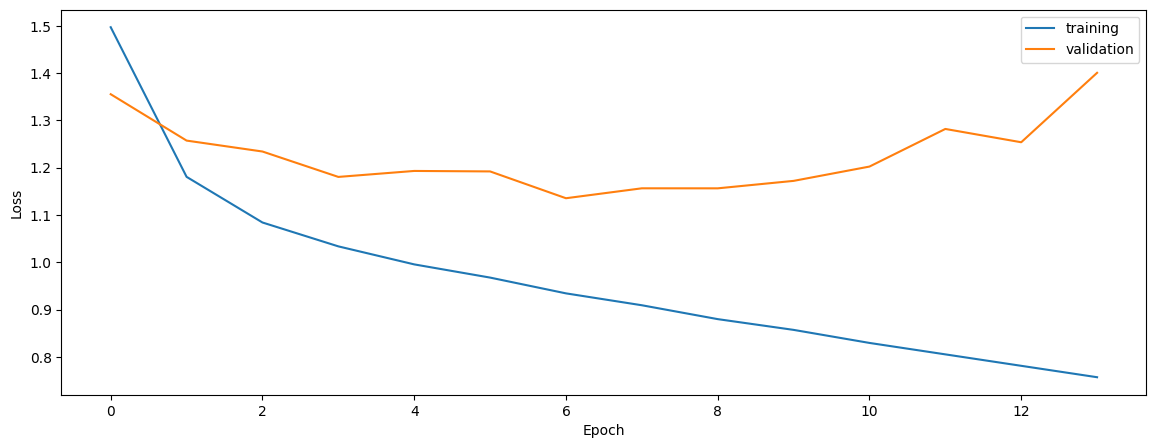

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6270987499397913
0.5685935427183295
0.6005706134094151


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5617963343220017
0.5429754733218589
0.533255529863444


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5642102271259141
0.5434041148641214
0.5400795906765208


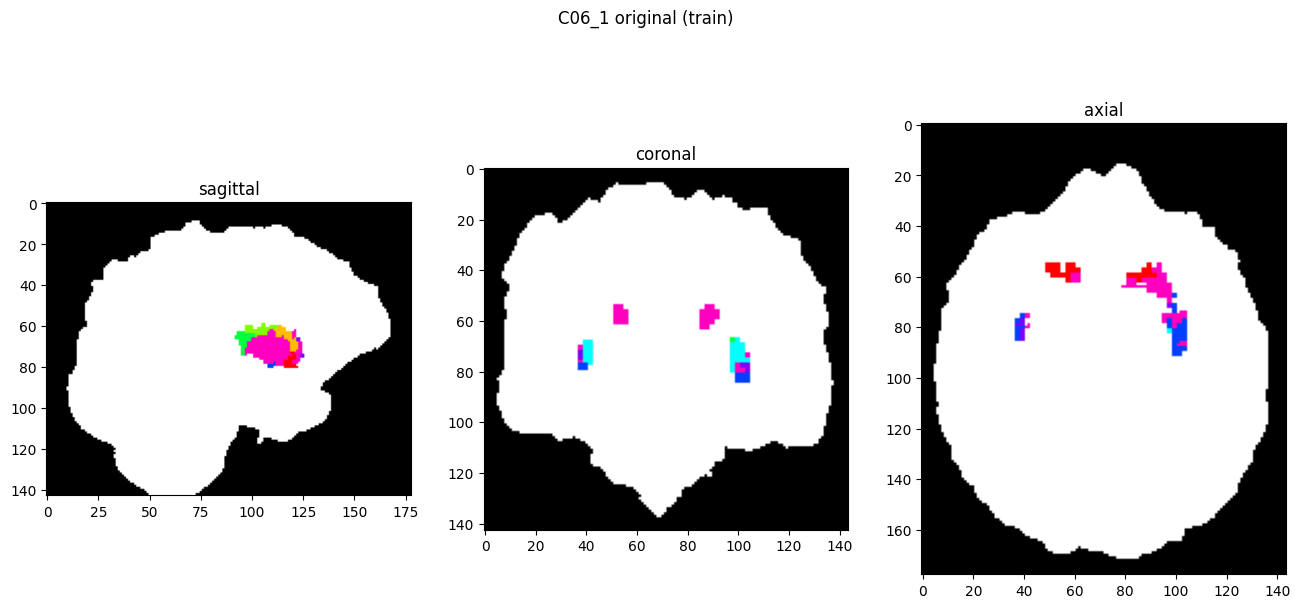

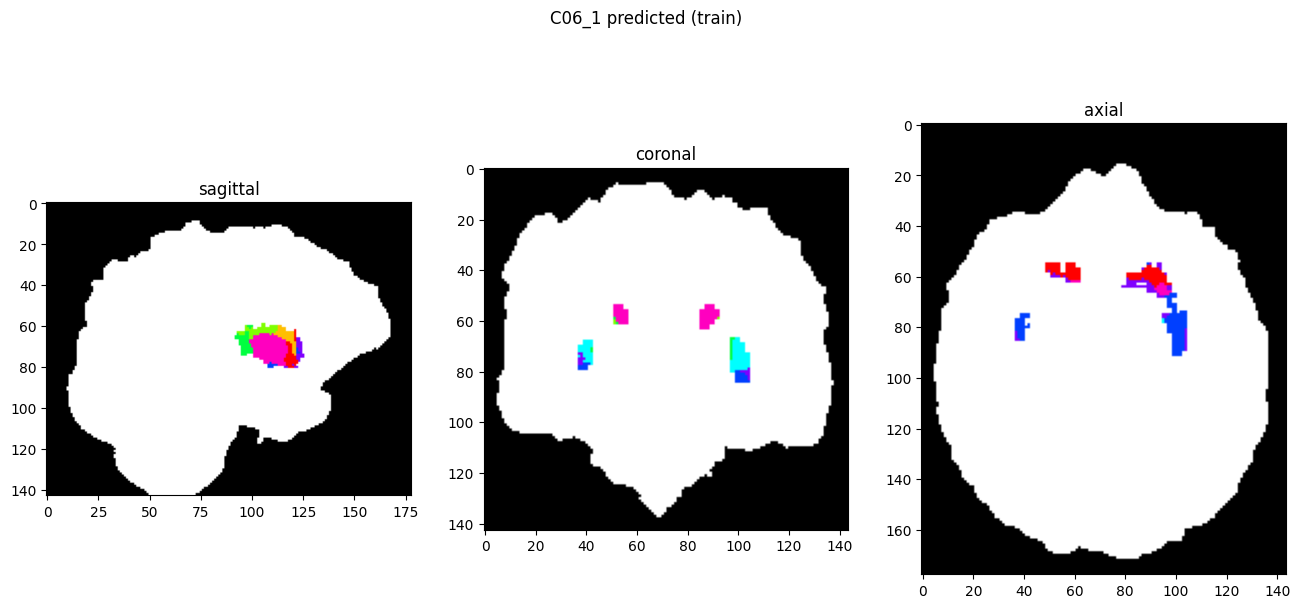

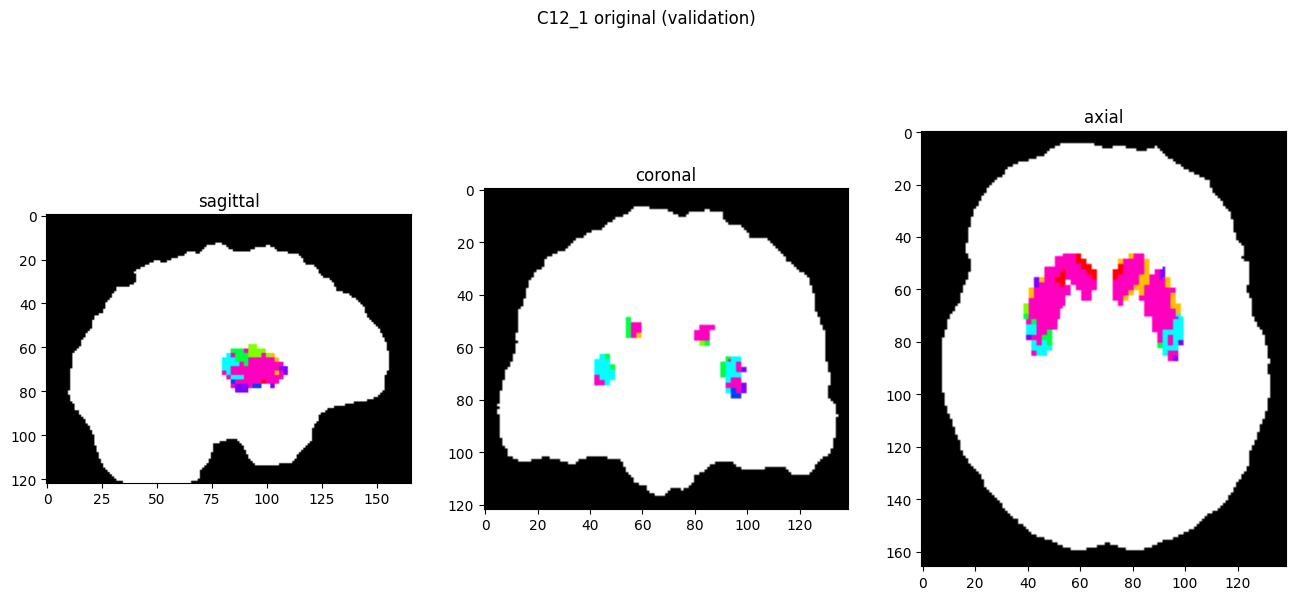

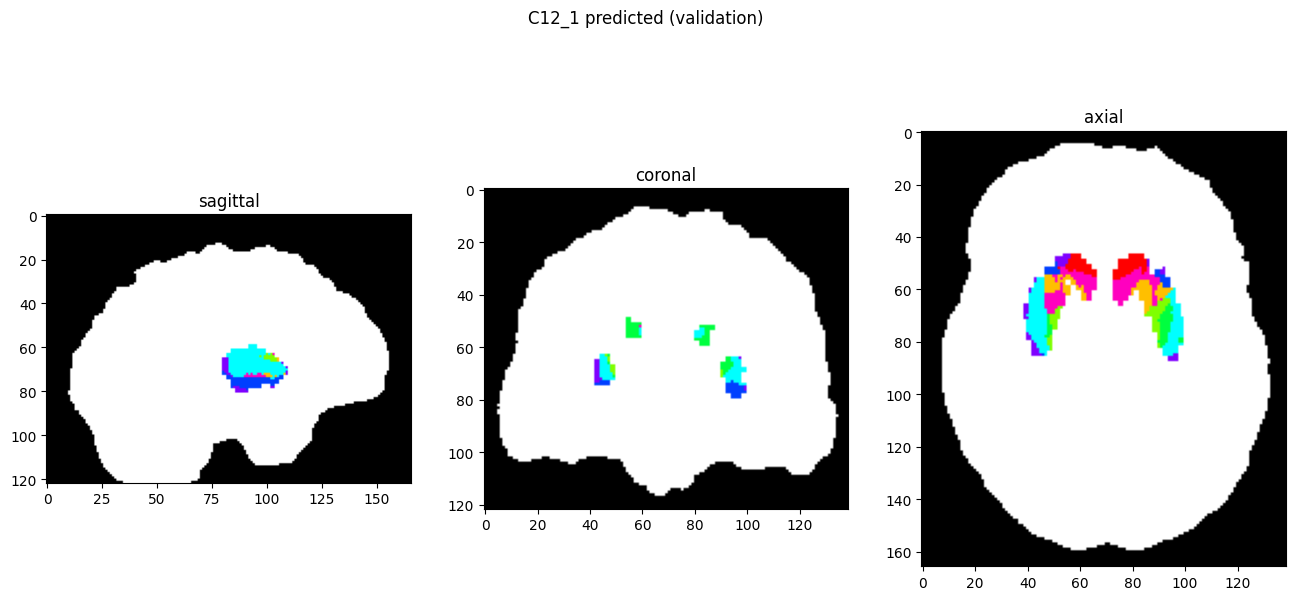

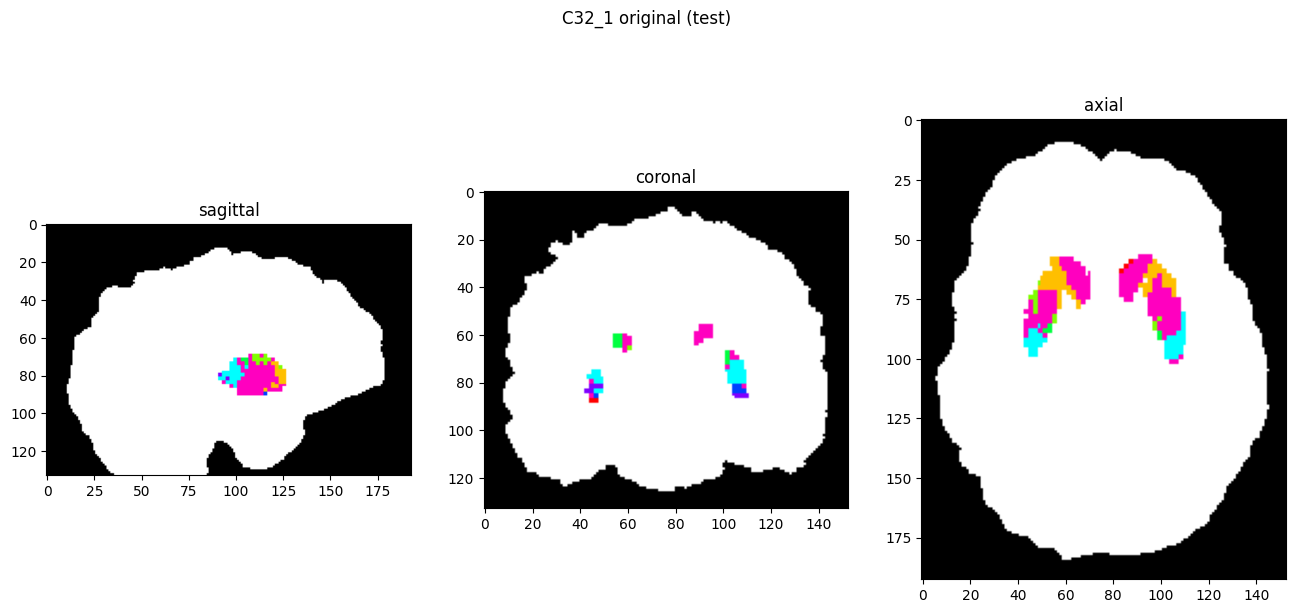

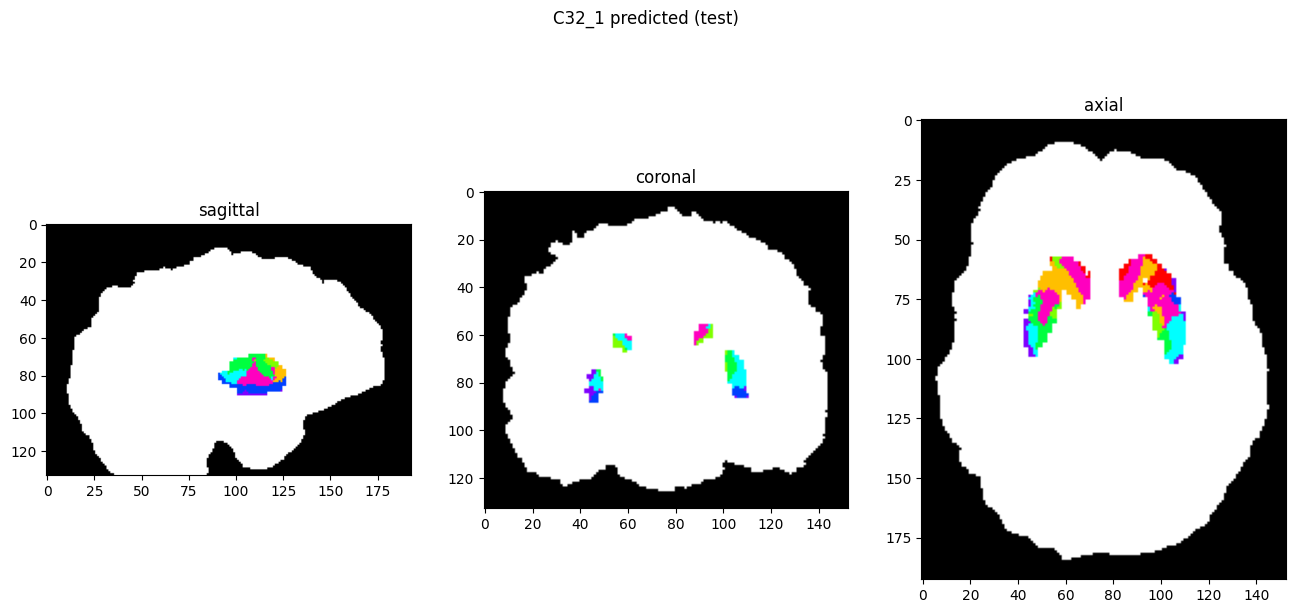

In [10]:
showResults(model, gen, threshold=0)